# HDBSCAN - Análise do segmento baixa renda para perfil laranja

## Configurações do ambiente

pip install -q neoway-dataviz-tools

In [ ]:
pip install shap plotly hdbscan  seaborn matplotlib

Looking in indexes: https://pypi.org/simple, https://git.neoway.io/api/v4/projects/273/packages/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from feature_store import Catalog, FeatureStore
from functools import reduce
import gcsfs
import hdbscan
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import shap
import subprocess
import time
import pyspark.sql.functions as sf

from pyspark.ml.feature import VectorAssembler
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import (
    col, count, mean, monotonically_increasing_id, row_number, sum, when
)
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.window import Window

# import dataviz_tools.categorical as categorical_viz

In [ ]:
TIMESTAMP = "oculto"

In [ ]:
sandbox_analytics= 'oculto'

## Feature Store

In [ ]:
fs = FeatureStore(spark)

You are currently in the PROD environment.


In [ ]:
catalog = fs.get_catalog(reference_timestamp=oculto)

## Bases de Dados

### Recorte - Baixa Renda

In [ ]:
BASE_GS = 'oculto'

In [ ]:
pessoa = (
    spark.read.parquet(os.path.join(BASE_GS, 'CADASTRAIS.parquet/'))
    .join(
        spark.read.parquet(os.path.join(BASE_GS, 'RENDA.parquet/')), on='cpf', how='inner'
    )
    .withColumn("idoso", sf.when(sf.col("idade") >= 60, 1).otherwise(0))
    .withColumn("adolescente", sf.when((sf.col("idade") >= 12) & (sf.col("idade") <= 18), 1).otherwise(0))
)

In [ ]:
pf_baixa_renda = pessoa.filter(sf.col('flagBaixaRenda') == 1)

In [ ]:
DATASET_NAME = 'patrimonio.parquet'
PATH = os.path.join(BASE_GS, 'oculto/')

60.39 da base de dados de pessoa são classificados como baixa renda

### Dados - Censitários

In [ ]:
df_setor = spark.read.parquet(os.path.join(BASE_GS, 'ENDERECO.parquet/'))


In [ ]:
df_setor = (
    pf_baixa_renda
    .join(df_setor, how='inner', on='cpf')
)

In [ ]:
df_setor.printSchema()

In [ ]:
df_setor.limit(5).toPandas()

### Financiamento de Imoveis (B3)

In [ ]:
imoveis_financiados = (
    catalog.read("oculto")
    .join(pf_baixa_renda, on='cpf', how='right')
    .withColumn("faixaFinanciamento",
                sf.when(
                    (
                        (sf.col("descFaixaFinanciamentoMaisAtualAtivo").isNull()) |
                        (sf.col("descFaixaFinanciamentoMaisAtualAtivo") == "NA")
                    ) &
                    (sf.col("descFaixaFinanciamentoMaisAtualQuitado").isNotNull()), sf.col("descFaixaFinanciamentoMaisAtualQuitado"))
                .otherwise(sf.col("descFaixaFinanciamentoMaisAtualAtivo"))
               )
    .withColumn("qntdFinanciamentosImobiliarios", sf.col("qteFinanciamentoAtivo") + sf.col("qteFinanciamentoQuitado"))
    .fillna("NA", subset=["faixaFinanciamento"])
    .fillna(0, subset=["qntdFinanciamentosImobiliarios", "qteFinanciamentoAtivo", "qteFinanciamentoQuitado"])
    .select("cpf", "faixaFinanciamento", "qntdFinanciamentosImobiliarios", "qteFinanciamentoAtivo", "qteFinanciamentoQuitado")
)

### Financiamento de Veículos (B3)

In [ ]:
catalogo_sng = (
    catalog.read("oculto")
    .select("cpf",
            "qteVeiculoFinanciadoHistorico",
            "qteTotalCompraVeiculo",
            "valFinanciadoMedia",
            "valFinanciadoMediaParcela",
            "valFinanciadoSoma",
            "qteFinanciadoAtivo"
           )
)

### Investimentos

In [ ]:
investimento = (
    catalog.read("oculto")
    .join(pf_baixa_renda.select("cpf"), on="cpf", how="right")
    .select("cpf", "ativosComCota", "ativosSemCota", "bancarizacao",
            "diversificacao", "patrimonio")
)

### Veículos Pesados

In [ ]:
cols = ["cpf", "quantidadeVeiculosPesados"]

In [ ]:
veiculos_pesado = (
    catalog.read("oculto")
    .select(*cols)
    .join(pf_baixa_renda.select("cpf"), on="cpf", how="right")
    .fillna(0)
)

### Aeronaves

In [ ]:
cols = ["cpf", "quantidadeAeronaves"]

In [ ]:
aeronaves = (
    catalog.read("oculto")
    .select(*cols)
    .join(pf_baixa_renda.select("cpf"), on="cpf", how="right")
    .fillna(0)
)

### Propriedades Rurais

In [ ]:
cols = ["cpf", "valorAreaTotalPropriedadesRurais",
        "quantidadePropriedades"]

In [ ]:
pessoa_propriedades_rurais = (
    catalog.read("oculto")
    .select(*cols)
    .join(pf_baixa_renda.select("cpf"), how="right", on="cpf")
    .fillna(0)
)

## Modelagem

In [ ]:
def countMissingValues(dataframe: DataFrame) -> DataFrame:
    missing_values = dataframe.select([
        sf.count(sf.when(sf.col(c).isNull(), c)).alias(c) for c in dataframe.columns
    ])

    return missing_values

In [ ]:
def mapearFaixas(faixa):
    for f, value in mapFaixasImobiliario.items():
        if faixa == f:
                return value

In [ ]:
mapear_udf = sf.udf(lambda x : mapearFaixas(x), IntegerType())

In [ ]:
mapFaixasImobiliario = {
    "0 A 200000": 1,
    "200001 A 400000": 2,
    "400001 A 600000": 3,
    "600001 A 800000": 4,
    "800001 A 1000000": 5,
    "1000001 A 2000000": 6,
    "2000001 A 3000000": 7,
    "3000001 A 4000000": 8,
    "4000001 A 5000000": 9,
    "5000001 A 6000000": 10,
    "6000001 A 7000000": 11,
    "7000001 A 8000000": 12,
    "8000001 A 9000000": 13,
    "9000001 A 10000000": 14,
    "10000001 A 25000000": 15,
    "ACIMA DE 25000000": 16
}

In [ ]:
mapFaixasInvestimento = {
    "A": 1,
    "B": 2,
    "C": 3,
    "D": 4,
    "E": 5,
    "F": 6,
    "G": 7,
    "H": 8,
    "I": 9,
    "J": 10,
    "K": 11,
    "L": 12,
    "M": 13,
    "N": 14,
    "O": 15,
    "P": 16,
    "Q": 17,
    "R": 18,
    "S": 19,
    "T": 20,
    "U": 21,
    "V": 22,
}

In [ ]:
def mapearFaixasInvestimento(faixa):
    for f, value in mapFaixasInvestimento.items():
        if faixa == f:
                return value

In [ ]:
mapear_investimento_udf = sf.udf(lambda x : mapearFaixasInvestimento(x), IntegerType())

In [ ]:
datasets = [pf_baixa_renda.select("cpf", "idade"),
            imoveis_financiados,
            investimento, veiculos_pesado,
            aeronaves, pessoa_propriedades_rurais]

In [ ]:
df = reduce(lambda left, right: left.join(right, on="cpf", how="left"), datasets)

In [ ]:
df = (
    df
    .drop("ctaFinanciadorMarcaPremium", "ctaHistoricoAtrasoFinanciamento", "ctaMediaParcelaFinanciamento",
          "faixaValorImobiliarioMedio", "faixaFinanciamento", "ativosComCota",
          "ativosSemCota", "bancarizacao", "diversificacao", "patrimonio",
          "ctaRecorrenciaFinanciamento"
         )
)

In [ ]:
def read_parquet_to_pandas(path: str, projectGCS="oculto"):
    """function to read parquet file as
     as pandas dataframe - useful for
     training tasks"""
    fs = gcsfs.GCSFileSystem(project=projectGCS, requester_pays=True)
    files = ["gs://" + path for path in fs.glob(path + "/part-*")]
    df_pandas = pq.ParquetDataset(files, filesystem=fs).read().to_pandas()
    return df_pandas

In [ ]:
def get_unique_values_with_counts(df, column_name):
    """
    Retorna os valores únicos de uma coluna em um DataFrame PySpark e a contagem de ocorrências.

    Parâmetros:
    df (DataFrame): O DataFrame PySpark.
    column_name (str): O nome da coluna que queremos analisar.

    Retorna:
    Lista de tuplas (valor, contagem).
    """
    return (
        df.groupBy(column_name)
        .agg(count("*").alias("total"))
        .orderBy(col("total").desc())  # Ordena pelo maior número de registros
        .collect()
    )


In [ ]:
dataset = pf_baixa_renda.drop("nome", "dataIndicioFalecimento", "flagSituacaoRegular", "tempoEmAnosDataNascimentoDataInscricao",
                              "flagAltaRenda", "flagMediaRenda", "situacao", "idoso", "adolescente", "flagRendaSemInformacao", "flagBaixaRenda")

In [ ]:
datasetCpfIdadeProfissao = dataset
dataset = dataset.drop("idade", "cpf", "profissao")


In [ ]:
def convert_none_true(df, column_name):

    return df.withColumn(
        column_name,
        when(col(column_name).isNull(), 0)
        .when(col(column_name) == True, 1)
        .when(col(column_name) == False, 0)
        .otherwise(0)
        .cast("int")
    )

In [ ]:
dataset = convert_none_true(dataset, "indicioFalecimento")


In [ ]:
feature_cols = [
    "flagFalecidoConfirmado", "flagSupercentenario", "flagAdolescente", "flagIdoso",
    "flagEmpresario", "flagAltaQualificacao", "flagServidorPublico", "flagRegistroAntt",
    "flagProdutorRural", "indicioFalecimento"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
dataset = assembler.transform(dataset)

In [ ]:
dataset_total = dataset

In [ ]:
datasetSemFeatures = dataset.drop("features")

In [ ]:
window_spec = Window.orderBy("features")

dataset = dataset.withColumn("row_id", row_number().over(window_spec) - 1)

In [ ]:
dataset = dataset_total.limit(10000000)

## Schemas dos Datasets Bases

In [ ]:
df.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- idade: integer (nullable = true)
 |-- qntdFinanciamentosImobiliarios: long (nullable = true)
 |-- qteFinanciamentoAtivo: long (nullable = true)
 |-- qteFinanciamentoQuitado: long (nullable = true)
 |-- quantidadeVeiculosPesados: long (nullable = true)
 |-- quantidadeAeronaves: long (nullable = true)
 |-- valorAreaTotalPropriedadesRurais: double (nullable = true)
 |-- quantidadePropriedades: long (nullable = true)



In [ ]:
pf_baixa_renda.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- nome: string (nullable = true)
 |-- idade: integer (nullable = true)
 |-- situacao: string (nullable = true)
 |-- indicioFalecimento: boolean (nullable = true)
 |-- dataIndicioFalecimento: date (nullable = true)
 |-- flagFalecidoConfirmado: integer (nullable = true)
 |-- flagSituacaoRegular: integer (nullable = true)
 |-- tempoEmAnosDataNascimentoDataInscricao: double (nullable = true)
 |-- flagSupercentenario: integer (nullable = true)
 |-- flagAdolescente: integer (nullable = true)
 |-- flagIdoso: integer (nullable = true)
 |-- flagEmpresario: integer (nullable = true)
 |-- flagAltaQualificacao: integer (nullable = true)
 |-- profissao: string (nullable = true)
 |-- flagServidorPublico: integer (nullable = true)
 |-- flagRegistroAntt: integer (nullable = true)
 |-- flagProdutorRural: integer (nullable = true)
 |-- flagRendaSemInformacao: integer (nullable = true)
 |-- flagBaixaRenda: integer (nullable = true)
 |-- flagMediaRenda: integer (

In [ ]:
datasetCpfIdadeProfissao.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- idade: integer (nullable = true)
 |-- indicioFalecimento: boolean (nullable = true)
 |-- flagFalecidoConfirmado: integer (nullable = true)
 |-- flagSupercentenario: integer (nullable = true)
 |-- flagAdolescente: integer (nullable = true)
 |-- flagIdoso: integer (nullable = true)
 |-- flagEmpresario: integer (nullable = true)
 |-- flagAltaQualificacao: integer (nullable = true)
 |-- profissao: string (nullable = true)
 |-- flagServidorPublico: integer (nullable = true)
 |-- flagRegistroAntt: integer (nullable = true)
 |-- flagProdutorRural: integer (nullable = true)



In [ ]:
dataset.printSchema()

root
 |-- indicioFalecimento: integer (nullable = false)
 |-- flagFalecidoConfirmado: integer (nullable = true)
 |-- flagSupercentenario: integer (nullable = true)
 |-- flagAdolescente: integer (nullable = true)
 |-- flagIdoso: integer (nullable = true)
 |-- flagEmpresario: integer (nullable = true)
 |-- flagAltaQualificacao: integer (nullable = true)
 |-- flagServidorPublico: integer (nullable = true)
 |-- flagRegistroAntt: integer (nullable = true)
 |-- flagProdutorRural: integer (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
df_setor.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- nome: string (nullable = true)
 |-- idade: integer (nullable = true)
 |-- situacao: string (nullable = true)
 |-- indicioFalecimento: boolean (nullable = true)
 |-- dataIndicioFalecimento: date (nullable = true)
 |-- flagFalecidoConfirmado: integer (nullable = true)
 |-- flagSituacaoRegular: integer (nullable = true)
 |-- tempoEmAnosDataNascimentoDataInscricao: double (nullable = true)
 |-- flagSupercentenario: integer (nullable = true)
 |-- flagAdolescente: integer (nullable = true)
 |-- flagIdoso: integer (nullable = true)
 |-- flagEmpresario: integer (nullable = true)
 |-- flagAltaQualificacao: integer (nullable = true)
 |-- profissao: string (nullable = true)
 |-- flagServidorPublico: integer (nullable = true)
 |-- flagRegistroAntt: integer (nullable = true)
 |-- flagProdutorRural: integer (nullable = true)
 |-- flagRendaSemInformacao: integer (nullable = true)
 |-- flagBaixaRenda: integer (nullable = true)
 |-- flagMediaRenda: integer (

In [ ]:
imoveis_financiados.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- faixaFinanciamento: string (nullable = false)
 |-- qntdFinanciamentosImobiliarios: long (nullable = true)
 |-- qteFinanciamentoAtivo: long (nullable = true)
 |-- qteFinanciamentoQuitado: long (nullable = true)



In [ ]:
catalogo_sng.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- qteVeiculoFinanciadoHistorico: long (nullable = true)
 |-- qteTotalCompraVeiculo: long (nullable = true)
 |-- valFinanciadoMedia: long (nullable = true)
 |-- valFinanciadoMediaParcela: long (nullable = true)
 |-- valFinanciadoSoma: long (nullable = true)
 |-- qteFinanciadoAtivo: long (nullable = true)



In [ ]:
investimento.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- ativosComCota: string (nullable = true)
 |-- ativosSemCota: string (nullable = true)
 |-- bancarizacao: string (nullable = true)
 |-- diversificacao: string (nullable = true)
 |-- patrimonio: string (nullable = true)



In [ ]:
veiculos_pesado.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- quantidadeVeiculosPesados: long (nullable = true)



In [ ]:
aeronaves.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- quantidadeAeronaves: long (nullable = true)



In [ ]:
pessoa_propriedades_rurais.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- valorAreaTotalPropriedadesRurais: double (nullable = false)
 |-- quantidadePropriedades: long (nullable = true)



## Visão Geral dos Datasets

In [ ]:
df.limit(5).toPandas()

,cpf,idade,qntdFinanciamentosImobiliarios,qteFinanciamentoAtivo,qteFinanciamentoQuitado,quantidadeVeiculosPesados,quantidadeAeronaves,valorAreaTotalPropriedadesRurais,quantidadePropriedades
0,00000024295,38,0,0,0,0,0,0.0,0
1,00000156604,51,0,0,0,0,0,0.0,0
2,00000194530,43,0,0,0,0,0,0.0,0
3,00000284602,57,1,1,0,0,0,0.0,0
4,00000335290,47,0,0,0,0,0,0.0,0


In [ ]:
pf_baixa_renda.limit(5).toPandas()

In [ ]:
datasetCpfIdadeProfissao.limit(5).toPandas()

,cpf,idade,indicioFalecimento,flagFalecidoConfirmado,flagSupercentenario,flagAdolescente,flagIdoso,flagEmpresario,flagAltaQualificacao,profissao,flagServidorPublico,flagRegistroAntt,flagProdutorRural
0,00000016276,46,None,0,0,0,0,0,0,None,0,0,0
1,00000024295,38,None,0,0,0,0,0,0,None,0,0,0
2,00000028282,36,None,0,0,0,0,0,0,None,0,0,0
3,00000144355,42,None,0,0,0,0,0,0,None,0,0,0
4,00000156604,51,None,0,0,0,0,0,0,None,0,0,0


In [ ]:
dataset.limit(5).toPandas()

,indicioFalecimento,flagFalecidoConfirmado,flagSupercentenario,flagAdolescente,flagIdoso,flagEmpresario,flagAltaQualificacao,flagServidorPublico,flagRegistroAntt,flagProdutorRural,features
0,0,0,0,0,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
1,0,0,0,0,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
2,0,0,0,0,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
3,0,0,0,0,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
4,0,0,0,0,0,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


In [ ]:
df_setor.limit(5).toPandas()

In [ ]:
imoveis_financiados.limit(5).toPandas()

,cpf,faixaFinanciamento,qntdFinanciamentosImobiliarios,qteFinanciamentoAtivo,qteFinanciamentoQuitado
0,00000016276,NA,0,0,0
1,00000024295,NA,0,0,0
2,00000028282,NA,0,0,0
3,00000144355,NA,0,0,0
4,00000156604,NA,0,0,0


In [ ]:
catalogo_sng.limit(5).toPandas()

,cpf,qteVeiculoFinanciadoHistorico,qteTotalCompraVeiculo,valFinanciadoMedia,valFinanciadoMediaParcela,valFinanciadoSoma,qteFinanciadoAtivo
0,81628650559,1.0,1,10216,NaN,10216,0
1,70988458411,NaN,1,11954,332.0,11954,0
2,66283817904,5.0,5,14299,546.0,71498,0
3,72036761615,1.0,1,6238,249.0,6238,0
4,25682181859,NaN,1,19757,411.0,19757,1


## Investigação dos Dados

In [ ]:
catalogo_sng.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- qteVeiculoFinanciadoHistorico: long (nullable = true)
 |-- qteTotalCompraVeiculo: long (nullable = true)
 |-- valFinanciadoMedia: long (nullable = true)
 |-- valFinanciadoMediaParcela: long (nullable = true)
 |-- valFinanciadoSoma: long (nullable = true)
 |-- qteFinanciadoAtivo: long (nullable = true)



In [ ]:
valores_situacao = get_unique_values_with_counts(catalogo_sng, "qteVeiculoFinanciadoHistorico")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

1: 18798085 registros
None: 16356848 registros
2: 7909152 registros
3: 4069031 registros
4: 2269074 registros
5: 1326569 registros
6: 804962 registros
7: 502643 registros
8: 323684 registros
9: 213305 registros
10: 143817 registros
11: 99604 registros
12: 70277 registros
13: 50562 registros
14: 37131 registros
15: 27748 registros
16: 20594 registros
17: 15685 registros
18: 12196 registros
19: 9620 registros
20: 7607 registros
21: 6035 registros
22: 4730 registros
23: 3931 registros
24: 3240 registros
25: 2701 registros
26: 2234 registros
27: 1781 registros
28: 1539 registros
29: 1270 registros
30: 1060 registros
31: 951 registros
32: 748 registros
33: 687 registros
34: 597 registros
35: 460 registros
36: 406 registros
37: 402 registros
38: 337 registros
39: 277 registros
40: 241 registros
42: 201 registros
41: 194 registros
43: 175 registros
44: 149 registros
46: 136 registros
45: 118 registros
47: 110 registros
50: 96 registros
48: 93 registros
51: 85 registros
49: 75 registros
52: 69

In [ ]:
valores_situacao = get_unique_values_with_counts(catalogo_sng, "qteTotalCompraVeiculo")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

1: 26092553 registros
2: 11520724 registros
3: 6086026 registros
4: 3478569 registros
5: 2074711 registros
6: 1281744 registros
7: 813140 registros
8: 528627 registros
9: 351449 registros
10: 238640 registros
11: 164893 registros
12: 116167 registros
13: 84020 registros
14: 61516 registros
15: 45488 registros
16: 33949 registros
17: 25965 registros
18: 20025 registros
19: 15506 registros
20: 12414 registros
21: 9924 registros
22: 7922 registros
23: 6376 registros
24: 5138 registros
25: 4137 registros
26: 3513 registros
27: 3043 registros
28: 2431 registros
29: 2060 registros
30: 1735 registros
31: 1453 registros
32: 1241 registros
33: 1059 registros
34: 917 registros
35: 801 registros
36: 690 registros
37: 555 registros
38: 511 registros
39: 472 registros
40: 377 registros
41: 347 registros
42: 335 registros
44: 283 registros
43: 258 registros
45: 210 registros
46: 169 registros
47: 160 registros
48: 139 registros
49: 131 registros
50: 121 registros
51: 112 registros
52: 96 registros
5

In [ ]:
valores_situacao = get_unique_values_with_counts(catalogo_sng, "valFinanciadoMedia")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

In [ ]:
valores_situacao = get_unique_values_with_counts(catalogo_sng, "valFinanciadoMediaParcela")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

In [ ]:
valores_situacao = get_unique_values_with_counts(catalogo_sng, "valFinanciadoSoma")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

In [ ]:
valores_situacao = get_unique_values_with_counts(catalogo_sng, "qteFinanciadoAtivo")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

0: 36348277 registros
1: 14540379 registros
2: 1791043 registros
3: 307104 registros
4: 75072 registros
5: 23765 registros
6: 9202 registros
7: 4031 registros
8: 2095 registros
9: 1076 registros
10: 587 registros
11: 380 registros
12: 294 registros
13: 182 registros
14: 125 registros
15: 79 registros
16: 70 registros
17: 65 registros
18: 44 registros
20: 36 registros
19: 27 registros
21: 22 registros
24: 16 registros
22: 15 registros
26: 15 registros
25: 14 registros
23: 14 registros
27: 6 registros
28: 6 registros
32: 5 registros
29: 5 registros
34: 5 registros
31: 4 registros
38: 4 registros
35: 4 registros
41: 3 registros
36: 3 registros
39: 3 registros
40: 3 registros
49: 2 registros
86: 2 registros
47: 2 registros
43: 2 registros
46: 2 registros
65: 2 registros
44: 1 registros
183: 1 registros
66: 1 registros
50: 1 registros
126: 1 registros
48: 1 registros
89: 1 registros
33: 1 registros
30: 1 registros
90: 1 registros


In [ ]:
from pyspark.sql.functions import col

print_df = catalogo_sng.filter(col("cpf") == 21995508004).limit(10).toPandas()
print_df


,cpf,qteVeiculoFinanciadoHistorico,qteTotalCompraVeiculo,valFinanciadoMedia,valFinanciadoMediaParcela,valFinanciadoSoma,qteFinanciadoAtivo
0,21995508004,27,171,65144,1764,10944349,126


In [ ]:
investimento.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- ativosComCota: string (nullable = true)
 |-- ativosSemCota: string (nullable = true)
 |-- bancarizacao: string (nullable = true)
 |-- diversificacao: string (nullable = true)
 |-- patrimonio: string (nullable = true)



In [ ]:
valores_situacao = get_unique_values_with_counts(investimento, "ativosComCota")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

None: 105230892 registros
P: 1135253 registros
O: 836313 registros
N: 500479 registros
Q: 420305 registros
M: 369950 registros
L: 332018 registros
K: 296712 registros
I: 249891 registros
J: 241023 registros
F: 240661 registros
H: 235874 registros
D: 224315 registros
G: 206037 registros
E: 194782 registros
C: 191416 registros
B: 128203 registros
A: 19791 registros


In [ ]:
valores_situacao = get_unique_values_with_counts(investimento, "ativosSemCota")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

None: 109442554 registros
S: 296068 registros
R: 226519 registros
Q: 147096 registros
P: 146966 registros
N: 118856 registros
M: 100659 registros
L: 86957 registros
O: 76666 registros
K: 70631 registros
J: 55400 registros
I: 53743 registros
H: 48253 registros
G: 43342 registros
F: 36855 registros
E: 34228 registros
D: 27974 registros
C: 23788 registros
B: 12093 registros
A: 5267 registros


In [ ]:
valores_situacao = get_unique_values_with_counts(investimento, "bancarizacao")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

None: 84130121 registros
C: 16716968 registros
B: 5312552 registros
A: 4894274 registros


In [ ]:
valores_situacao = get_unique_values_with_counts(investimento, "diversificacao")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

None: 104223715 registros
D: 5902173 registros
C: 612160 registros
B: 269542 registros
A: 39193 registros
E: 7132 registros


In [ ]:
valores_situacao = get_unique_values_with_counts(investimento, "patrimonio")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

None: 104204503 registros
Q: 2189225 registros
P: 720847 registros
N: 533164 registros
O: 477320 registros
M: 346644 registros
L: 329909 registros
K: 328004 registros
G: 308790 registros
J: 280778 registros
H: 276688 registros
I: 247716 registros
E: 237701 registros
F: 223508 registros
D: 216756 registros
C: 108999 registros
B: 19195 registros
A: 4168 registros


In [ ]:
veiculos_pesado.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- quantidadeVeiculosPesados: long (nullable = true)



In [ ]:
valores_situacao = get_unique_values_with_counts(veiculos_pesado, "quantidadeVeiculosPesados")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

0: 110842594 registros
1: 174202 registros
2: 28994 registros
3: 5943 registros
4: 1468 registros
5: 415 registros
6: 132 registros
7: 63 registros
8: 27 registros
10: 14 registros
9: 13 registros
11: 6 registros
54: 5 registros
15: 4 registros
14: 4 registros
19: 3 registros
22: 3 registros
13: 2 registros
12: 2 registros
16: 2 registros
20: 2 registros
116: 1 registros
37: 1 registros
31: 1 registros
43: 1 registros
53: 1 registros
35: 1 registros
25: 1 registros
23: 1 registros
60: 1 registros
34: 1 registros
520: 1 registros
28: 1 registros
18: 1 registros
40: 1 registros
17: 1 registros
94: 1 registros
128: 1 registros


In [ ]:
aeronaves.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- quantidadeAeronaves: long (nullable = true)



In [ ]:
valores_situacao = get_unique_values_with_counts(aeronaves, "quantidadeAeronaves")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

0: 111053877 registros
1: 34 registros
2: 3 registros
3: 1 registros


In [ ]:
pessoa_propriedades_rurais.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- valorAreaTotalPropriedadesRurais: double (nullable = false)
 |-- quantidadePropriedades: long (nullable = true)



In [ ]:
valores_situacao = get_unique_values_with_counts(pessoa_propriedades_rurais, "valorAreaTotalPropriedadesRurais")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

In [ ]:
valores_situacao = get_unique_values_with_counts(pessoa_propriedades_rurais, "quantidadePropriedades")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

0: 110866740 registros
1: 182629 registros
2: 4371 registros
3: 160 registros
4: 12 registros
5: 2 registros
6: 1 registros


In [ ]:
imoveis_financiados.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- faixaFinanciamento: string (nullable = false)
 |-- qntdFinanciamentosImobiliarios: long (nullable = true)
 |-- qteFinanciamentoAtivo: long (nullable = true)
 |-- qteFinanciamentoQuitado: long (nullable = true)



In [ ]:
valores_situacao = get_unique_values_with_counts(imoveis_financiados, "faixaFinanciamento")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

NA: 109374135 registros
0 A 200000: 1481335 registros
200001 A 400000: 171270 registros
400001 A 600000: 18064 registros
600001 A 800000: 4854 registros
800001 A 1000000: 2033 registros
1000001 A 2000000: 1879 registros
2000001 A 3000000: 203 registros
3000001 A 4000000: 59 registros
4000001 A 5000000: 41 registros
10000001 A 25000000: 12 registros
7000001 A 8000000: 7 registros
6000001 A 7000000: 6 registros
5000001 A 6000000: 6 registros
9000001 A 10000000: 4 registros
8000001 A 9000000: 4 registros
ACIMA DE 25000000: 3 registros


In [ ]:
valores_situacao = get_unique_values_with_counts(imoveis_financiados, "qntdFinanciamentosImobiliarios")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

0: 109374125 registros
1: 1644928 registros
2: 29814 registros
3: 4305 registros
4: 495 registros
5: 91 registros
6: 30 registros
7: 17 registros
8: 11 registros
12: 6 registros
14: 5 registros
10: 5 registros
20: 4 registros
25: 4 registros
13: 4 registros
38: 4 registros
23: 4 registros
11: 4 registros
27: 4 registros
22: 3 registros
21: 3 registros
31: 3 registros
16: 3 registros
26: 3 registros
17: 3 registros
15: 3 registros
48: 2 registros
39: 2 registros
30: 2 registros
32: 2 registros
9: 2 registros
24: 2 registros
60: 2 registros
28: 2 registros
42: 2 registros
46: 1 registros
51: 1 registros
62: 1 registros
45: 1 registros
37: 1 registros
19: 1 registros
47: 1 registros
50: 1 registros
29: 1 registros
34: 1 registros
35: 1 registros
58: 1 registros
52: 1 registros
33: 1 registros
41: 1 registros
36: 1 registros


In [ ]:
valores_situacao = get_unique_values_with_counts(imoveis_financiados, "qteFinanciamentoAtivo")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

0: 109426844 registros
1: 1602782 registros
2: 20840 registros
3: 3051 registros
4: 237 registros
5: 36 registros
6: 13 registros
7: 8 registros
12: 6 registros
8: 6 registros
14: 5 registros
20: 4 registros
25: 4 registros
13: 4 registros
23: 4 registros
10: 4 registros
27: 4 registros
38: 4 registros
22: 3 registros
21: 3 registros
26: 3 registros
31: 3 registros
17: 3 registros
16: 3 registros
9: 3 registros
15: 3 registros
11: 3 registros
32: 2 registros
42: 2 registros
28: 2 registros
48: 2 registros
60: 2 registros
39: 2 registros
24: 2 registros
30: 2 registros
46: 1 registros
51: 1 registros
36: 1 registros
34: 1 registros
35: 1 registros
58: 1 registros
52: 1 registros
33: 1 registros
41: 1 registros
29: 1 registros
50: 1 registros
62: 1 registros
37: 1 registros
45: 1 registros
19: 1 registros
47: 1 registros


In [ ]:
valores_situacao = get_unique_values_with_counts(imoveis_financiados, "qteFinanciamentoQuitado")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

0: 110990666 registros
1: 61406 registros
2: 1620 registros
3: 176 registros
4: 33 registros
5: 11 registros
6: 2 registros
7: 1 registros


In [ ]:
df.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- idade: integer (nullable = true)
 |-- qntdFinanciamentosImobiliarios: long (nullable = true)
 |-- qteFinanciamentoAtivo: long (nullable = true)
 |-- qteFinanciamentoQuitado: long (nullable = true)
 |-- quantidadeVeiculosPesados: long (nullable = true)
 |-- quantidadeAeronaves: long (nullable = true)
 |-- valorAreaTotalPropriedadesRurais: double (nullable = true)
 |-- quantidadePropriedades: long (nullable = true)



In [ ]:
valores_situacao = get_unique_values_with_counts(df, "qntdFinanciamentosImobiliarios")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

In [ ]:
valores_situacao = get_unique_values_with_counts(df, "qteFinanciamentoQuitado")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

In [ ]:
valores_situacao = get_unique_values_with_counts(df, "quantidadeVeiculosPesados")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

In [ ]:
valores_situacao = get_unique_values_with_counts(df, "quantidadeAeronaves")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

In [ ]:
valores_situacao = get_unique_values_with_counts(df, "valorAreaTotalPropriedadesRurais")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

In [ ]:
valores_situacao = get_unique_values_with_counts(df, "quantidadePropriedades")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

In [ ]:
df_setor.printSchema()

In [ ]:
valores_situacao = get_unique_values_with_counts(df_setor, "flagMediaRenda")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

0: 111053915 registros


In [ ]:
valores_situacao = get_unique_values_with_counts(df_setor, "flagAltaRenda")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

0: 111053915 registros


In [ ]:
valores_situacao = get_unique_values_with_counts(df_setor, "flagAreaUrbanaBaixaDensidadeEdificios")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

0: 106723099 registros
1: 4330816 registros


In [ ]:
valores_situacao = get_unique_values_with_counts(df_setor, "flagAglomeradoRural")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

0: 110723626 registros
1: 330289 registros


In [ ]:
valores_situacao = get_unique_values_with_counts(df_setor, "flagAreaRural")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

0: 95454661 registros
1: 15599254 registros


In [ ]:
valores_situacao = get_unique_values_with_counts(df_setor, "flagFavelaOuComunidadeUrbana")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

0: 106040896 registros
1: 5013019 registros


## Import de datasets

In [ ]:
BASE_GS = "oculto"

In [ ]:
DATASET_NAME = 'isolation.parquet'
PATH = os.path.join(BASE_GS, 'oculto/isolation.parquet')

In [ ]:
dataset = spark.read.parquet(PATH)

In [ ]:
dataset.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- tempoEmAnosDataNascimentoDataInscricao: double (nullable = true)
 |-- flagAdolescente: integer (nullable = true)
 |-- flagIdoso: integer (nullable = true)
 |-- flagEmpresario: integer (nullable = true)
 |-- flagAltaQualificacao: integer (nullable = true)
 |-- flagServidorPublico: integer (nullable = true)
 |-- flagProdutorRural: integer (nullable = true)
 |-- flagVulneravelBPC: integer (nullable = true)
 |-- flagBeneficiarioProgramasSociais: integer (nullable = true)
 |-- flagAltaQualificacaoBeneficiarioProgramasSociais: integer (nullable = true)
 |-- flagDuplaIdentidadeNomeDataNascimento: boolean (nullable = true)
 |-- quantidadeDuplaIdentidadeNomeMae: long (nullable = true)
 |-- flagDuplaIdentidadeNomeMae: boolean (nullable = true)
 |-- quantidadeDuplaIdentidadeCpfMae: long (nullable = true)
 |-- flagDuplaIdentidadeCpfMae: boolean (nullable = true)
 |-- quantidadeIndicioForteDuplaIdentidade: long (nullable = true)
 |-- flagIndicioForteDupl

In [ ]:
dataset.count()

10000000

In [ ]:
dataset.limit(5).toPandas()

,cpf,tempoEmAnosDataNascimentoDataInscricao,flagAdolescente,flagIdoso,flagEmpresario,flagAltaQualificacao,flagServidorPublico,flagProdutorRural,flagVulneravelBPC,flagBeneficiarioProgramasSociais,...,valorAreaTotalPropriedadesRurais,quantidadePropriedades,flagFinanciadorMarcaPremium,flagPossuiHistoricoAtrasoFinanciamento,faixaFinanciamentoImobiliario,ativosComCotaMapeado,ativosSemCotaMapeado,bancarizacaoMapeado,diversificacaoMapeado,patrimonioMapeado
0,00015209385,18.13,0,0,1,1,0,0,0,0,...,0.0,0,0,0,0,0,0,2,0,0
1,00030195438,18.26,0,0,1,0,0,0,0,1,...,0.0,0,0,0,0,0,0,0,0,0
2,00037251970,19.24,0,0,0,0,0,0,0,0,...,0.0,0,0,1,0,0,0,0,0,0
3,00037903985,18.76,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,0,0
4,00052705102,16.92,0,0,1,0,0,0,0,0,...,0.0,0,0,0,0,0,0,3,0,0


In [ ]:
oculto.count()

2460395

In [ ]:
dataset.printSchema()

root
 |-- cpf: string (nullable = true)
 |-- tempoEmAnosDataNascimentoDataInscricao: double (nullable = true)
 |-- flagAdolescente: integer (nullable = true)
 |-- flagIdoso: integer (nullable = true)
 |-- flagEmpresario: integer (nullable = true)
 |-- flagAltaQualificacao: integer (nullable = true)
 |-- flagServidorPublico: integer (nullable = true)
 |-- flagProdutorRural: integer (nullable = true)
 |-- flagVulneravelBPC: integer (nullable = true)
 |-- flagBeneficiarioProgramasSociais: integer (nullable = true)
 |-- flagAltaQualificacaoBeneficiarioProgramasSociais: integer (nullable = true)
 |-- flagDuplaIdentidadeNomeDataNascimento: boolean (nullable = true)
 |-- quantidadeDuplaIdentidadeNomeMae: long (nullable = true)
 |-- flagDuplaIdentidadeNomeMae: boolean (nullable = true)
 |-- quantidadeDuplaIdentidadeCpfMae: long (nullable = true)
 |-- flagDuplaIdentidadeCpfMae: boolean (nullable = true)
 |-- quantidadeIndicioForteDuplaIdentidade: long (nullable = true)
 |-- flagIndicioForteDupl

## Modelos

### Configurações do Modelo

In [ ]:
dataset = dataset.drop("cpf", "nome", "situacao", "dataIndicioFalecimento", "flagFalecidoConfirmado", "flagSituacaoRegular",
                       "tempoEmAnosDataNascimentoDataInscricao", "idoso", "adolescente", "profissao")

In [ ]:
valores_situacao = get_unique_values_with_counts(dataset, "cpf")

for valor, total in valores_situacao:
    print(f"{valor}: {total} registros")

In [ ]:
from pyspark.ml.feature import VectorAssembler

feature_cols = [
    "flagAdolescente", "flagIdoso", "flagEmpresario", "flagAltaQualificacao", "flagServidorPublico",
    "flagProdutorRural", "flagVulneravelBPC", "flagBeneficiarioProgramasSociais",
    "flagAltaQualificacaoBeneficiarioProgramasSociais", "flagDuplaIdentidadeNomeDataNascimento",
    "quantidadeDuplaIdentidadeNomeMae", "flagDuplaIdentidadeNomeMae", "quantidadeDuplaIdentidadeCpfMae",
    "flagDuplaIdentidadeCpfMae", "quantidadeIndicioForteDuplaIdentidade", "flagIndicioForteDuplaIdentidade",
    "flagSocioDuplaId", "quantidadeMediaEmpresasMesmoCnaeAbertas12Meses", "flagSocioClasseEmpresaFachadaMEDIO",
    "flagSocioClasseEmpresaFachadaALTA", "flagSocioClasseEmpresaFachadaMUITOALTA", "qtdImoveis",
    "qtdImoveisAltoValor", "qntdFinanciamentosImobiliarios", "qteFinanciamentoAtivo", "qteFinanciamentoQuitado",
    "qteTotalCompraVeiculo", "valFinanciadoMedia", "valFinanciadoMediaParcela", "valFinanciadoSoma",
    "qteFinanciadoAtivo", "qtdVeiculosFinanciados", "qtdVeiculosAVista", "quantidadeVeiculosPesados",
    "quantidadeAeronaves", "valorAreaTotalPropriedadesRurais", "quantidadePropriedades",
    "flagFinanciadorMarcaPremium", "flagPossuiHistoricoAtrasoFinanciamento", "faixaFinanciamentoImobiliario",
    "ativosComCotaMapeado", "ativosSemCotaMapeado", "bancarizacaoMapeado", "diversificacaoMapeado",
    "patrimonioMapeado"
]

print("Criando vetor de features")
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
dataset = assembler.transform(dataset)

dataset.select("features").show(5, truncate=False)


Criando vetor de features


+--------------------------------------------------------------------------------+
|features                                                                        |
+--------------------------------------------------------------------------------+
|(45,[2,3,21,42],[1.0,1.0,1.0,2.0])                                              |
|(45,[2,7,8,26,27,28,29,31],[1.0,1.0,1.0,1.0,3307.0,55.0,3307.0,1.0])            |
|(45,[26,27,28,29,30,31,32,38],[2.0,20974.0,853.0,41949.0,1.0,1.0,1.0,1.0])      |
|(45,[26,27,28,29,31],[1.0,21884.0,364.0,21884.0,1.0])                           |
|(45,[2,18,26,27,28,29,31,32,42],[1.0,1.0,2.0,21376.0,424.0,42752.0,1.0,1.0,3.0])|
+--------------------------------------------------------------------------------+
only showing top 5 rows



In [ ]:
window_spec = Window.orderBy("features")

dataset = dataset.withColumn("row_id", row_number().over(window_spec) - 1)

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

dataset = dataset.withColumn("row_id", monotonically_increasing_id())


In [ ]:
unique_count = dataset.select("row_id").distinct().count()
print(f"Número de IDs únicos na coluna 'row_id': {unique_count}")


Número de IDs únicos na coluna 'row_id': 2460395


### HDBSCAN

In [ ]:
sandbox_analytics = 'gs://path_oculto/gabriel.willye/batches/'

In [ ]:
print("Carregando batches do GCS...")
batch_files = dataset

print("Processando os batches...")

batch_size = 100000
total_linhas = batch_files.count()
num_batches = (total_linhas // batch_size) + (1 if total_linhas % batch_size else 0)

print(f"Total de batches estimado: {num_batches}")

for i in range(num_batches):
    print(f"Processando batch {i+1}/{num_batches}...")

    batch = batch_files.limit(batch_size)

    pandas_df = batch.toPandas()

    if pandas_df.empty:
        print(f"Batch {i+1} está vazio. Pulando...")
        continue

    features_array = np.array(pandas_df["features"].apply(lambda x: x.toArray()).tolist())

    if features_array.shape[0] == 0:
        print(f"Nenhum dado válido no batch {i+1}. Pulando...")
        continue

    print(f"Executando HDBSCAN no batch {i+1} ({len(features_array)} registros)")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, metric='euclidean')
    labels = clusterer.fit_predict(features_array)

    pandas_df["cluster"] = labels
    spark_df = spark.createDataFrame(pandas_df)

    print(f"Salvando batch {i+1} com clusters...")
    spark_df.write.mode("append").parquet(f"{sandbox_analytics}hdbscan_batches_dataset.parquet")

print("Processamento finalizado!")

Carregando batches do GCS...
Processando os batches...


Total de batches estimado: 25
Processando batch 1/25...


Executando HDBSCAN no batch 1 (100000 registros)
Salvando batch 1 com clusters...


Processando batch 2/25...


Executando HDBSCAN no batch 2 (100000 registros)
Salvando batch 2 com clusters...


Processando batch 3/25...


Executando HDBSCAN no batch 3 (100000 registros)
Salvando batch 3 com clusters...


Processando batch 4/25...


Executando HDBSCAN no batch 4 (100000 registros)
Salvando batch 4 com clusters...


Processando batch 5/25...


Executando HDBSCAN no batch 5 (100000 registros)
Salvando batch 5 com clusters...


Processando batch 6/25...


Executando HDBSCAN no batch 6 (100000 registros)
Salvando batch 6 com clusters...


Processando batch 7/25...


Executando HDBSCAN no batch 7 (100000 registros)
Salvando batch 7 com clusters...


Processando batch 8/25...


Executando HDBSCAN no batch 8 (100000 registros)
Salvando batch 8 com clusters...


Processando batch 9/25...


Executando HDBSCAN no batch 9 (100000 registros)
Salvando batch 9 com clusters...


Processando batch 10/25...


Executando HDBSCAN no batch 10 (100000 registros)
Salvando batch 10 com clusters...


Processando batch 11/25...


Executando HDBSCAN no batch 11 (100000 registros)
Salvando batch 11 com clusters...


Processando batch 12/25...


Executando HDBSCAN no batch 12 (100000 registros)
Salvando batch 12 com clusters...


Processando batch 13/25...


Executando HDBSCAN no batch 13 (100000 registros)
Salvando batch 13 com clusters...


Processando batch 14/25...


Executando HDBSCAN no batch 14 (100000 registros)
Salvando batch 14 com clusters...


Processando batch 15/25...


Executando HDBSCAN no batch 15 (100000 registros)
Salvando batch 15 com clusters...


Processando batch 16/25...


Executando HDBSCAN no batch 16 (100000 registros)
Salvando batch 16 com clusters...


Processando batch 17/25...


Executando HDBSCAN no batch 17 (100000 registros)
Salvando batch 17 com clusters...


Processando batch 18/25...


Executando HDBSCAN no batch 18 (100000 registros)
Salvando batch 18 com clusters...


Processando batch 19/25...


Executando HDBSCAN no batch 19 (100000 registros)
Salvando batch 19 com clusters...


Processando batch 20/25...


Executando HDBSCAN no batch 20 (100000 registros)
Salvando batch 20 com clusters...


Processando batch 21/25...


Executando HDBSCAN no batch 21 (100000 registros)
Salvando batch 21 com clusters...


Processando batch 22/25...


Executando HDBSCAN no batch 22 (100000 registros)
Salvando batch 22 com clusters...


Processando batch 23/25...


Executando HDBSCAN no batch 23 (100000 registros)
Salvando batch 23 com clusters...


Processando batch 24/25...


Executando HDBSCAN no batch 24 (100000 registros)
Salvando batch 24 com clusters...


Processando batch 25/25...


Executando HDBSCAN no batch 25 (100000 registros)
Salvando batch 25 com clusters...


Processamento finalizado!


In [ ]:
spark_df.count()

25/02/25 20:03:13 WARN TaskSetManager: Stage 125 contains a task of very large size (2425 KiB). The maximum recommended task size is 1000 KiB.


100000

In [ ]:
data = spark.read.parquet("gs://path_oculto/gabriel.willye/batches/hdbscan_batches.parquet/")

In [ ]:
data.count()

7500000

In [ ]:
dataset = spark.read.parquet("gs://path_oculto/gabriel.willye/batches/hdbscan_batches_dataset.parquet/")

In [ ]:
dataset.count()

2500000

In [ ]:
dataset.groupBy("cluster").count().orderBy("count", ascending=False).toPandas()


,cluster,count
0,-1,543175
1,2061,33975
2,2029,22400
3,2056,12025
4,2014,6775
...,...,...
6910,1013,125
6911,2291,125
6912,3275,125
6913,3083,125


In [ ]:
data = data.drop("features")
df = data.toPandas()

comb_counts = df.value_counts().reset_index(name="count")

comb_counts = comb_counts.sort_values("count", ascending=True)

for _, row in comb_counts.iterrows():
    comb = ", ".join(map(str, row[:-1]))
    print(f"{comb} = {row['count']}")

In [ ]:
dataset = dataset.drop("features")
df = dataset.toPandas()

comb_counts = df.value_counts().reset_index(name="count")

comb_counts = comb_counts.sort_values("count", ascending=True)

for _, row in comb_counts.iterrows():
    comb = ", ".join(map(str, row[:-1]))
    print(f"{comb} = {row['count']}")

In [ ]:
clusters_df.groupBy("cluster").agg(
    {"flagAdolescente": "avg", "flagEmpresario": "avg", "flagAltaQualificacao": "avg"}
).toPandas()


4960395

## insumo

In [ ]:
dataset.printSchema()

root
 |-- flagAdolescente: long (nullable = true)
 |-- flagIdoso: long (nullable = true)
 |-- flagEmpresario: long (nullable = true)
 |-- flagAltaQualificacao: long (nullable = true)
 |-- flagServidorPublico: long (nullable = true)
 |-- flagProdutorRural: long (nullable = true)
 |-- flagVulneravelBPC: long (nullable = true)
 |-- flagBeneficiarioProgramasSociais: long (nullable = true)
 |-- flagAltaQualificacaoBeneficiarioProgramasSociais: long (nullable = true)
 |-- flagDuplaIdentidadeNomeDataNascimento: boolean (nullable = true)
 |-- quantidadeDuplaIdentidadeNomeMae: long (nullable = true)
 |-- flagDuplaIdentidadeNomeMae: boolean (nullable = true)
 |-- quantidadeDuplaIdentidadeCpfMae: long (nullable = true)
 |-- flagDuplaIdentidadeCpfMae: boolean (nullable = true)
 |-- quantidadeIndicioForteDuplaIdentidade: long (nullable = true)
 |-- flagIndicioForteDuplaIdentidade: boolean (nullable = true)
 |-- flagSocioDuplaId: long (nullable = true)
 |-- quantidadeMediaEmpresasMesmoCnaeAbertas12M

In [ ]:
outliers.limit(5).toPandas()

,flagAdolescente,flagIdoso,flagEmpresario,flagAltaQualificacao,flagServidorPublico,flagProdutorRural,flagVulneravelBPC,flagBeneficiarioProgramasSociais,flagAltaQualificacaoBeneficiarioProgramasSociais,flagDuplaIdentidadeNomeDataNascimento,quantidadeDuplaIdentidadeNomeMae,flagDuplaIdentidadeNomeMae,quantidadeDuplaIdentidadeCpfMae,flagDuplaIdentidadeCpfMae,quantidadeIndicioForteDuplaIdentidade,flagIndicioForteDuplaIdentidade,flagSocioDuplaId,quantidadeMediaEmpresasMesmoCnaeAbertas12Meses,flagSocioClasseEmpresaFachadaMEDIO,flagSocioClasseEmpresaFachadaALTA,flagSocioClasseEmpresaFachadaMUITOALTA,qtdImoveis,qtdImoveisAltoValor,qntdFinanciamentosImobiliarios,qteFinanciamentoAtivo,qteFinanciamentoQuitado,qteTotalCompraVeiculo,valFinanciadoMedia,valFinanciadoMediaParcela,valFinanciadoSoma,qteFinanciadoAtivo,qtdVeiculosFinanciados,qtdVeiculosAVista,quantidadeVeiculosPesados,quantidadeAeronaves,valorAreaTotalPropriedadesRurais,quantidadePropriedades,flagFinanciadorMarcaPremium,flagPossuiHistoricoAtrasoFinanciamento,faixaFinanciamentoImobiliario,ativosComCotaMapeado,ativosSemCotaMapeado,bancarizacaoMapeado,diversificacaoMapeado,patrimonioMapeado,cluster
0,0,0,1,0,0,0,0,0,0,False,0,False,0,False,0,False,0,0.0,1,0,0,0,0,0,0,0,1,2644,73,2644,0,1,0,0,0,0.0,0,0,0,0,0,0,0,0,0,-1
1,0,0,0,0,0,0,0,0,0,False,0,False,0,False,0,False,0,0.0,0,0,0,0,0,0,0,0,4,18952,365,75809,0,3,1,0,0,0.0,0,0,1,0,0,0,0,0,0,-1
2,0,0,0,0,0,0,0,0,0,False,0,False,0,False,0,False,0,0.0,0,0,0,0,0,0,0,0,2,6639,218,13278,1,2,0,0,0,0.0,0,0,0,0,0,13,3,4,15,-1
3,0,0,0,0,0,0,0,0,0,False,0,False,0,False,0,False,0,0.0,0,0,0,0,0,0,0,0,5,9466,329,37864,0,4,1,0,0,0.0,0,0,0,0,0,0,0,0,0,-1
4,0,0,0,0,0,0,0,1,1,False,0,False,0,False,0,False,0,0.0,0,0,0,0,0,0,0,0,2,5175,109,10350,1,1,1,0,0,0.0,0,0,0,0,13,0,3,4,15,-1


In [ ]:
outliers.printSchema()

root
 |-- flagAdolescente: long (nullable = true)
 |-- flagIdoso: long (nullable = true)
 |-- flagEmpresario: long (nullable = true)
 |-- flagAltaQualificacao: long (nullable = true)
 |-- flagServidorPublico: long (nullable = true)
 |-- flagProdutorRural: long (nullable = true)
 |-- flagVulneravelBPC: long (nullable = true)
 |-- flagBeneficiarioProgramasSociais: long (nullable = true)
 |-- flagAltaQualificacaoBeneficiarioProgramasSociais: long (nullable = true)
 |-- flagDuplaIdentidadeNomeDataNascimento: boolean (nullable = true)
 |-- quantidadeDuplaIdentidadeNomeMae: long (nullable = true)
 |-- flagDuplaIdentidadeNomeMae: boolean (nullable = true)
 |-- quantidadeDuplaIdentidadeCpfMae: long (nullable = true)
 |-- flagDuplaIdentidadeCpfMae: boolean (nullable = true)
 |-- quantidadeIndicioForteDuplaIdentidade: long (nullable = true)
 |-- flagIndicioForteDuplaIdentidade: boolean (nullable = true)
 |-- flagSocioDuplaId: long (nullable = true)
 |-- quantidadeMediaEmpresasMesmoCnaeAbertas12M

In [ ]:
boolean_cols = [c for c, dtype in outliers.dtypes if dtype == "boolean"]

for c in boolean_cols:
    outliers = outliers.withColumn(c, when(col(c) == True, 1).otherwise(0))


In [ ]:
all_cols = [c for c, dtype in outliers.dtypes]

mean_values = outliers.select([mean(col(c)).alias(f"media_{c}") for c in all_cols])

In [ ]:
outliers.write.mode("append").parquet(f"{sandbox_analytics}hdbscan_outliers.parquet")

## Baixar dataset geral

In [ ]:
dataset = spark.read.parquet("gs://path_oculto/gabriel.willye/batches/hdbscan_batches_dataset.parquet/")

In [ ]:
dataset.printSchema()

root
 |-- flagAdolescente: long (nullable = true)
 |-- flagIdoso: long (nullable = true)
 |-- flagEmpresario: long (nullable = true)
 |-- flagAltaQualificacao: long (nullable = true)
 |-- flagServidorPublico: long (nullable = true)
 |-- flagProdutorRural: long (nullable = true)
 |-- flagVulneravelBPC: long (nullable = true)
 |-- flagBeneficiarioProgramasSociais: long (nullable = true)
 |-- flagAltaQualificacaoBeneficiarioProgramasSociais: long (nullable = true)
 |-- flagDuplaIdentidadeNomeDataNascimento: boolean (nullable = true)
 |-- quantidadeDuplaIdentidadeNomeMae: long (nullable = true)
 |-- flagDuplaIdentidadeNomeMae: boolean (nullable = true)
 |-- quantidadeDuplaIdentidadeCpfMae: long (nullable = true)
 |-- flagDuplaIdentidadeCpfMae: boolean (nullable = true)
 |-- quantidadeIndicioForteDuplaIdentidade: long (nullable = true)
 |-- flagIndicioForteDuplaIdentidade: boolean (nullable = true)
 |-- flagSocioDuplaId: long (nullable = true)
 |-- quantidadeMediaEmpresasMesmoCnaeAbertas12M

## Baixar outliers

In [ ]:
outliers = spark.read.parquet('gs://path_oculto/gabriel.willye/batches/hdbscan_outliers.parquet')

In [ ]:
from pyspark.sql.functions import col

outliers = dataset.filter(col("cluster") == -1)
dataset_sem_outliers = dataset.filter(col("cluster") != -1)

## Resultados dos clusters

In [ ]:
dataset.groupBy("cluster").count().orderBy("count", ascending=False).toPandas()

,cluster,count
0,-1,543175
1,2061,33975
2,2029,22400
3,2056,12025
4,2014,6775
...,...,...
6910,4588,125
6911,3253,125
6912,525,125
6913,5542,125


In [ ]:
mean_values.toPandas()

,media_flagAdolescente,media_flagIdoso,media_flagEmpresario,media_flagAltaQualificacao,media_flagServidorPublico,media_flagProdutorRural,media_flagVulneravelBPC,media_flagBeneficiarioProgramasSociais,media_flagAltaQualificacaoBeneficiarioProgramasSociais,media_flagDuplaIdentidadeNomeDataNascimento,media_quantidadeDuplaIdentidadeNomeMae,media_flagDuplaIdentidadeNomeMae,media_quantidadeDuplaIdentidadeCpfMae,media_flagDuplaIdentidadeCpfMae,media_quantidadeIndicioForteDuplaIdentidade,media_flagIndicioForteDuplaIdentidade,media_flagSocioDuplaId,media_quantidadeMediaEmpresasMesmoCnaeAbertas12Meses,media_flagSocioClasseEmpresaFachadaMEDIO,media_flagSocioClasseEmpresaFachadaALTA,media_flagSocioClasseEmpresaFachadaMUITOALTA,media_qtdImoveis,media_qtdImoveisAltoValor,media_qntdFinanciamentosImobiliarios,media_qteFinanciamentoAtivo,media_qteFinanciamentoQuitado,media_qteTotalCompraVeiculo,media_valFinanciadoMedia,media_valFinanciadoMediaParcela,media_valFinanciadoSoma,media_qteFinanciadoAtivo,media_qtdVeiculosFinanciados,media_qtdVeiculosAVista,media_quantidadeVeiculosPesados,media_quantidadeAeronaves,media_valorAreaTotalPropriedadesRurais,media_quantidadePropriedades,media_flagFinanciadorMarcaPremium,media_flagPossuiHistoricoAtrasoFinanciamento,media_faixaFinanciamentoImobiliario,media_ativosComCotaMapeado,media_ativosSemCotaMapeado,media_bancarizacaoMapeado,media_diversificacaoMapeado,media_patrimonioMapeado,media_cluster
0,0.000046,0.229162,0.344502,0.036775,0.011276,0.018042,0.000368,0.115709,0.115709,0.009389,0.000092,0.000092,0.0,0.0,0.0,0.0,0.000828,0.012128,0.071524,0.0,0.0,0.047821,0.00046,0.053666,0.049524,0.004142,1.90689,13782.826391,471.209785,28905.563308,0.348368,1.576564,0.330326,0.014682,0.000046,0.008413,0.00695,0.013071,0.239426,0.066139,2.382105,0.875593,1.038846,0.913978,3.11106,-1.0


## Análise de PCA

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

In [ ]:
num_features = len([c for c in outliers.columns if c != "cluster"])

In [ ]:
feature_cols = [c for c in outliers.columns if c != "cluster"]

In [ ]:
feature_cols = [
    "flagAdolescente", "flagIdoso", "flagEmpresario", "flagAltaQualificacao",
    "flagServidorPublico", "flagProdutorRural", "flagVulneravelBPC",
    "flagBeneficiarioProgramasSociais", "flagAltaQualificacaoBeneficiarioProgramasSociais",
    "flagDuplaIdentidadeNomeDataNascimento", "quantidadeDuplaIdentidadeNomeMae",
    "flagDuplaIdentidadeNomeMae", "quantidadeDuplaIdentidadeCpfMae",
    "flagDuplaIdentidadeCpfMae", "quantidadeIndicioForteDuplaIdentidade",
    "flagIndicioForteDuplaIdentidade", "flagSocioDuplaId",
    "quantidadeMediaEmpresasMesmoCnaeAbertas12Meses", "flagSocioClasseEmpresaFachadaMEDIO",
    "flagSocioClasseEmpresaFachadaALTA", "flagSocioClasseEmpresaFachadaMUITOALTA",
    "qtdImoveis", "qtdImoveisAltoValor", "qntdFinanciamentosImobiliarios",
    "qteFinanciamentoAtivo", "qteFinanciamentoQuitado", "qteTotalCompraVeiculo",
    "valFinanciadoMedia", "valFinanciadoMediaParcela", "valFinanciadoSoma",
    "qteFinanciadoAtivo", "qtdVeiculosFinanciados", "qtdVeiculosAVista",
    "quantidadeVeiculosPesados", "quantidadeAeronaves",
    "valorAreaTotalPropriedadesRurais", "quantidadePropriedades",
    "flagFinanciadorMarcaPremium", "flagPossuiHistoricoAtrasoFinanciamento",
    "faixaFinanciamentoImobiliario", "ativosComCotaMapeado", "ativosSemCotaMapeado",
    "bancarizacaoMapeado", "diversificacaoMapeado", "patrimonioMapeado"
]

if "features" in outliers.columns:
    outliers = outliers.drop("features")

outliers = outliers.cache()
outliers.count()

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
outliers_vector = assembler.transform(outliers)

outliers_vector.select("features").show(5, truncate=False)


+------------------------------------------------------------------------------------------------------------+
|features                                                                                                    |
+------------------------------------------------------------------------------------------------------------+
|(45,[2,18,26,27,28,29,31],[1.0,1.0,1.0,2644.0,73.0,2644.0,1.0])                                             |
|(45,[26,27,28,29,31,32,38],[4.0,18952.0,365.0,75809.0,3.0,1.0,1.0])                                         |
|(45,[26,27,28,29,30,31,41,42,43,44],[2.0,6639.0,218.0,13278.0,1.0,2.0,13.0,3.0,4.0,15.0])                   |
|(45,[26,27,28,29,31,32],[5.0,9466.0,329.0,37864.0,4.0,1.0])                                                 |
|(45,[7,8,26,27,28,29,30,31,32,40,42,43,44],[1.0,1.0,2.0,5175.0,109.0,10350.0,1.0,1.0,1.0,13.0,3.0,4.0,15.0])|
+------------------------------------------------------------------------------------------------------------+
o

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
outliers_scaled = scaler.fit(outliers_vector).transform(outliers_vector)

In [ ]:
num_features = len(outliers_scaled.select("scaled_features").first()["scaled_features"])
k = min(num_features, 45)

print(k)

pca = PCA(k=k, inputCol="scaled_features", outputCol="pcaFeatures")
pca_model = pca.fit(outliers_scaled)
outliers_pca = pca_model.transform(outliers_scaled)

variance_explained = pca_model.explainedVariance.toArray()
pca_variance_dict = {f"PC{i+1}": var * 100 for i, var in enumerate(variance_explained)}

for pc, var in pca_variance_dict.items():
    print(f"{pc}: {var:.2f}% da variância explicada")


45


PC1: 9.31% da variância explicada
PC2: 7.70% da variância explicada
PC3: 6.79% da variância explicada
PC4: 5.52% da variância explicada
PC5: 5.18% da variância explicada
PC6: 4.82% da variância explicada
PC7: 3.75% da variância explicada
PC8: 3.66% da variância explicada
PC9: 3.23% da variância explicada
PC10: 2.79% da variância explicada
PC11: 2.75% da variância explicada
PC12: 2.64% da variância explicada
PC13: 2.60% da variância explicada
PC14: 2.57% da variância explicada
PC15: 2.56% da variância explicada
PC16: 2.54% da variância explicada
PC17: 2.52% da variância explicada
PC18: 2.49% da variância explicada
PC19: 2.48% da variância explicada
PC20: 2.46% da variância explicada
PC21: 2.39% da variância explicada
PC22: 2.36% da variância explicada
PC23: 2.31% da variância explicada
PC24: 2.26% da variância explicada
PC25: 2.09% da variância explicada
PC26: 2.01% da variância explicada
PC27: 1.62% da variância explicada
PC28: 1.52% da variância explicada
PC29: 1.49% da variância expl

In [ ]:
pcs = list(pca_variance_dict.keys())
variances = list(pca_variance_dict.values())

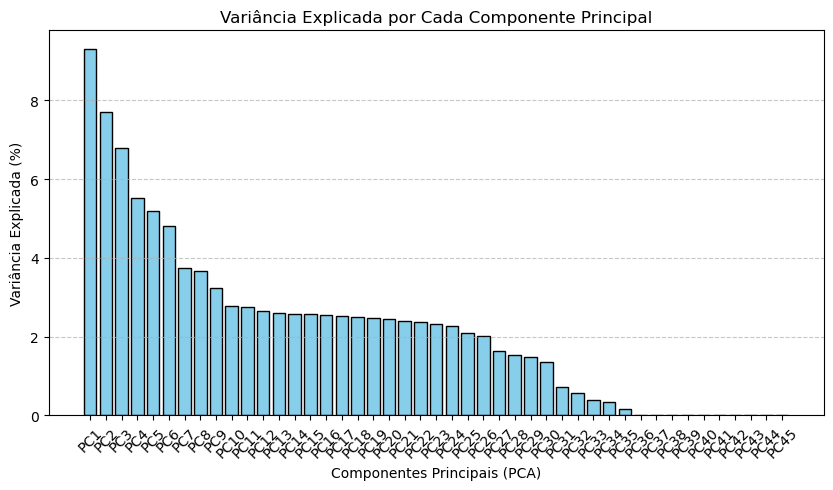

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(pcs, variances, color="skyblue", edgecolor="black")
plt.xlabel("Componentes Principais (PCA)")
plt.ylabel("Variância Explicada (%)")
plt.title("Variância Explicada por Cada Componente Principal")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Outras análises

### Matriz de Correlação

Análise para identificar quais variáveis são __fortemente correlacionadas__, mostrando possíveis padrões no dataset entre os outliers e o dataset com todos os clusters

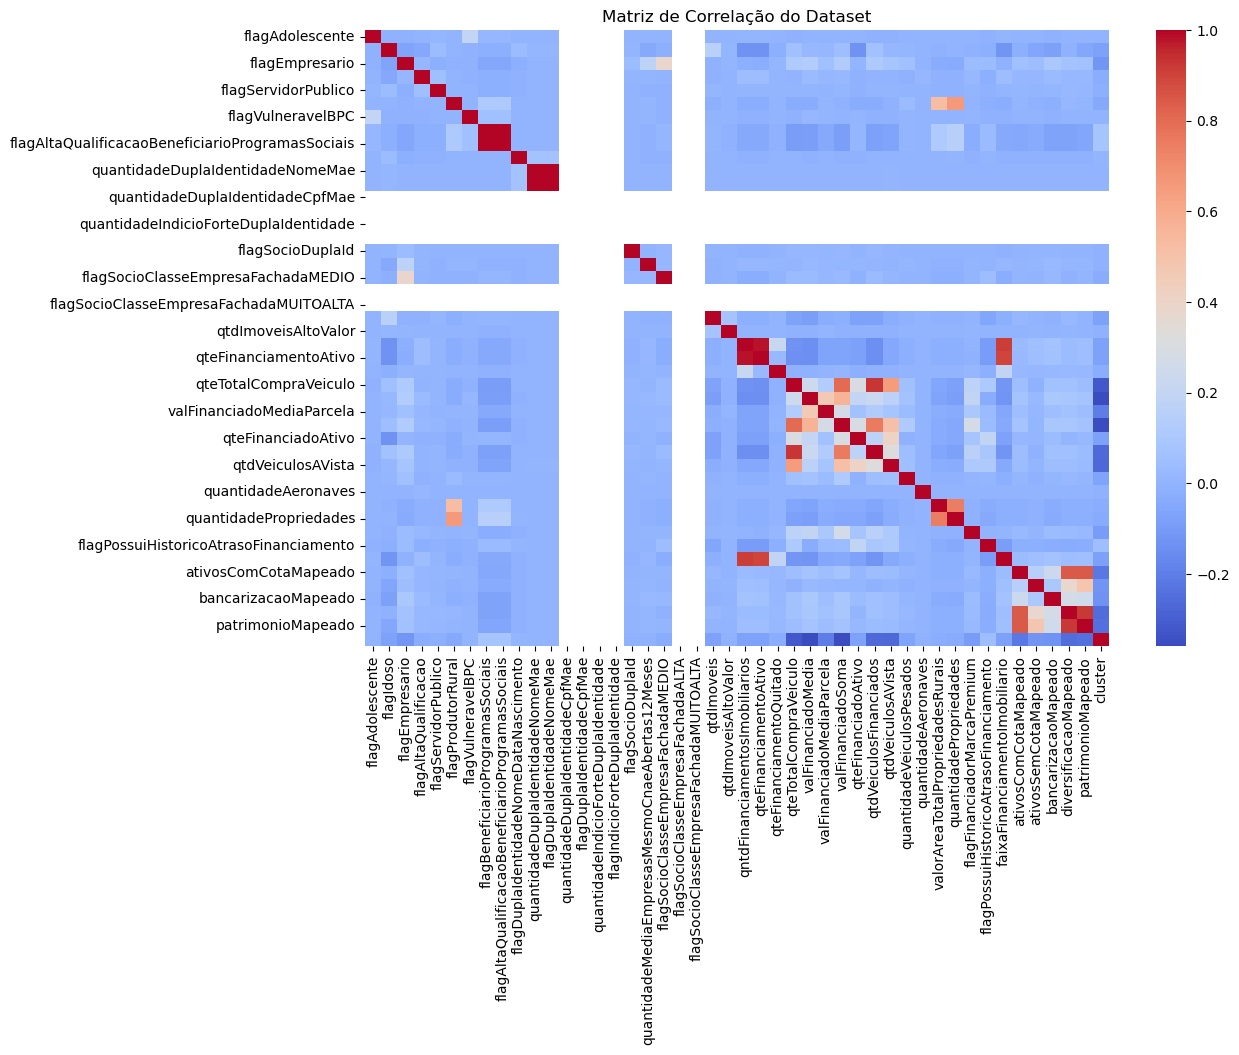

In [ ]:
df = dataset.toPandas()

df = df.drop(columns=["features"], errors="ignore")

for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)

corr_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Matriz de Correlação do Dataset")
plt.show()


### Análise de Distribuição de Features

Identificar como os dados de cada uma das features estão distribuídos entre os clusters

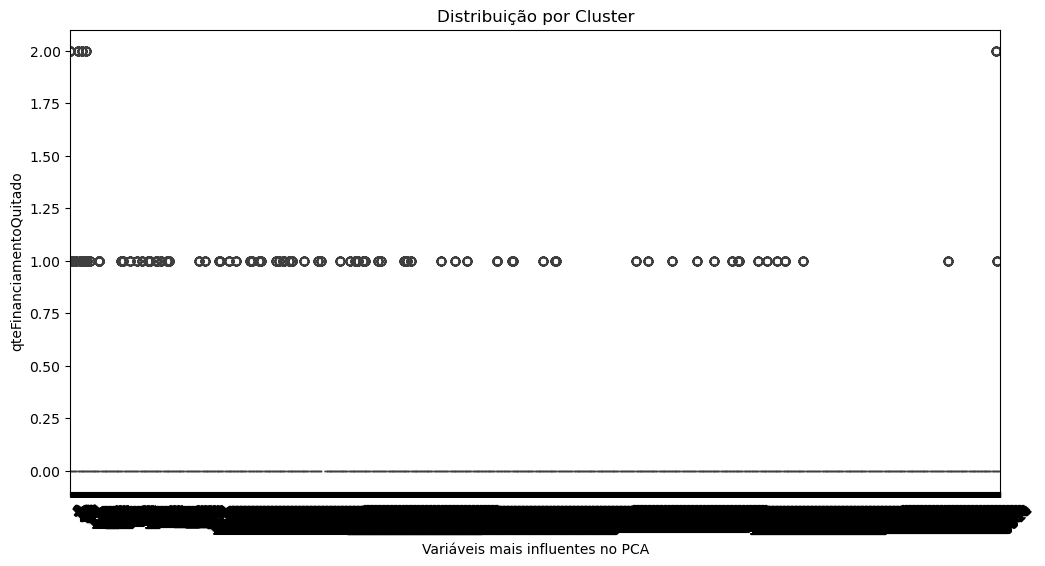

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="cluster", y="qteFinanciamentoQuitado", data=df)
plt.title("Distribuição por Cluster")
plt.xlabel("Variáveis mais influentes no PCA")
plt.xticks(rotation=45, ha='left')
plt.show()

### UMAP - Uniform Manifold Approximation and Projection

O __UMAP__ é um algoritmo de redução de dimensionalidade que preserva __estruturas locais e globais dos dados__, sendo útil para visualizar agrupamentos.
É útil para trabalhar com dados altamente dimensionais, preservando a estrutura dos clusters, podendo ser combinado para encontrar grupos mais coesos. Reduz as features para duas dimensões, agrupando os clusters de forma visual com cores diferentes, facilitando a interpretação da clusterização do HDBSCAN

In [ ]:
pip install umap umap-learn

Looking in indexes: https://pypi.org/simple, https://git.neoway.io/api/v4/projects/273/packages/pypi/simple
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.6 MB/s eta 0:00:00
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=6191b2a03b7641d42e15d178d831cb1e9c43feb757f99769b6ce8a4d96eaabc4
  Stored in directory: /root/.cache/pip/wheels/82/d8/73/e9eb3334baaad795ff0278363ff1aca7568bdf2793e452a527
Successfully built umap
Note: you may need to restart the kernel to use updated packages.


### Criar features array com dados de dataset

In [ ]:
pandas_df = outliers.toPandas()
features_array = np.array(pandas_df["features"].apply(lambda x: x.toArray()).tolist())

### SHAP - SHapley Additive Explanations

Explica como cada feature contribui para a formação dos clusters, fornecendo uma visão mais interpretável da clusterização. Ele ajuda a entender quais variáveis mais impactam cada cluster, e mostra a importância das features na separação dos grupos.

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://git.neoway.io/api/v4/projects/273/packages/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import shap

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, metric='euclidean')
labels = clusterer.fit_predict(features_array)

1


PermutationExplainer explainer: 1001it [18:04,  1.09s/it]                          


2


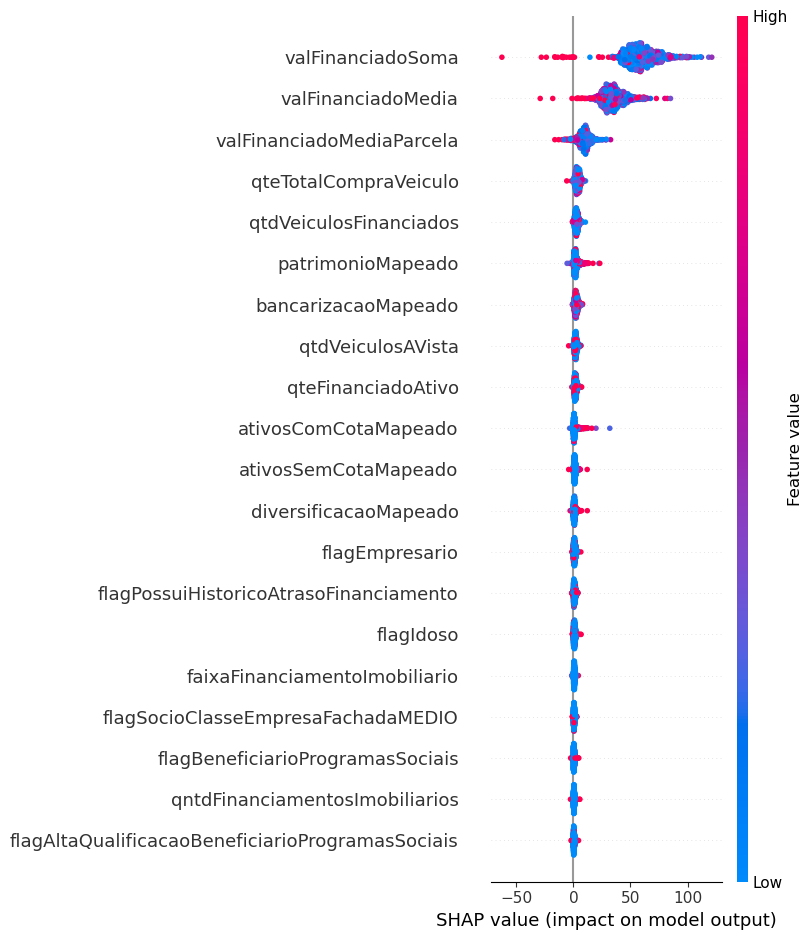

In [ ]:
explainer = shap.Explainer(lambda x: clusterer.fit_predict(x), features_array)

print("1")
shap_values = explainer(features_array[:1000])
print("2")
shap.summary_plot(shap_values.values, features_array[:1000], feature_names=pandas_df.columns[:-2])


### Análise de Correlação das variáveis

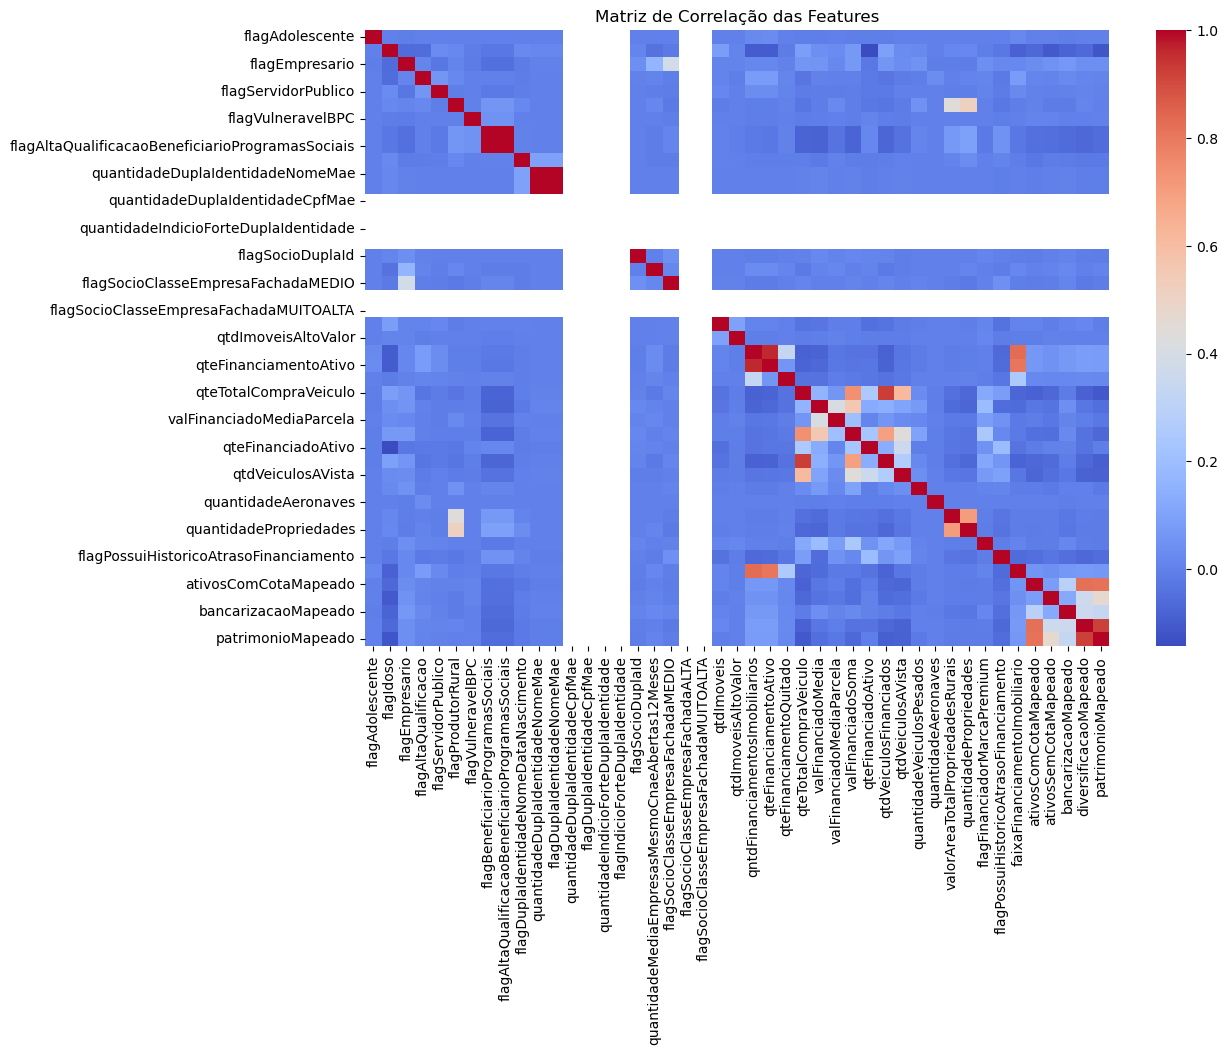

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(pandas_df.drop(columns=["cluster"]).corr(), cmap="coolwarm", annot=False)
plt.title("Matriz de Correlação das Features")
plt.show()

### T-SNE t-Distributed Stochastic Neighbor Embedding)

### T-Test e U-Test
Testes de inferência estatística para validar se os resultados obtidos foram obtidos de forma aleatória

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu

df_total = dataset_sem_outliers.toPandas().drop(columns=["features"], errors="ignore")
df_outliers = outliers.toPandas().drop(columns=["features"], errors="ignore")

for col in df_total.select_dtypes(include=['bool']).columns:
    df_total[col] = df_total[col].astype(int)
    df_outliers[col] = df_outliers[col].astype(int)

numeric_cols = df_total.select_dtypes(include=['int64', 'float64']).columns

results = []

for col in numeric_cols:
    group1 = df_total[col].dropna()
    group2 = df_outliers[col].dropna()

    # Teste t de Student
    t_stat, t_pvalue = ttest_ind(group1, group2, equal_var=False)

    # Teste U de Mann-Whitney
    u_stat, u_pvalue = mannwhitneyu(group1, group2, alternative="two-sided")

    results.append({
        "Variável": col,
        "T-Test (p=0.1)": "H1" if t_pvalue < 0.1 else "H0",
        "T-Test (p=0.05)": "H1" if t_pvalue < 0.05 else "H0",
        "U-Test (p=0.1)": "H1" if u_pvalue < 0.1 else "H0",
        "U-Test (p=0.05)": "H1" if u_pvalue < 0.05 else "H0"
    })

df_results = pd.DataFrame(results)

print(df_results)


/opt/conda/miniconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


                                            Variável T-Test (p=0.1)  \
0                                    flagAdolescente             H1   
1                                          flagIdoso             H1   
2                                     flagEmpresario             H1   
3                               flagAltaQualificacao             H1   
4                                flagServidorPublico             H1   
5                                  flagProdutorRural             H1   
6                                  flagVulneravelBPC             H1   
7                   flagBeneficiarioProgramasSociais             H1   
8   flagAltaQualificacaoBeneficiarioProgramasSociais             H1   
9              flagDuplaIdentidadeNomeDataNascimento             H1   
10                  quantidadeDuplaIdentidadeNomeMae             H1   
11                        flagDuplaIdentidadeNomeMae             H1   
12                   quantidadeDuplaIdentidadeCpfMae             H0   
13    

## Análise: Resultados obtidos com análise de outliers em baixa renda

#### Análise por médias presentes no cluster de outliers

Variáveis com valores médios mais altos de presença dentro dos outliers:
- Valor Financiado Soma
- Valor Financiado Média
- Quantidade de Financiado Ativo
- Quantidade de Veciulos Financiados
- Quantidade de Imoveis de Alto Valor
- Empresários: 34%
- Possuem Histórico de Atraso de Financiamento: 24%
- Idosos: 22%
- Beneficiários de Programas Sociais: 11%
- Alta Qualificação e Beneficiário de Programas Sociais: 11%
- Socio Classe Empresa Fachada Médio: 7%

#### Análise com base no t-SNE

O t-SNE permite analisar se o valor médio das variáveis é significativamente diferente do restante do dataset. Foi possível identificar diferença significativa na representatividade de _servidores públicos_, _financiadores de marcas premium (automóveis)_, _bancarização Mapeada_, _diversificação Mapeada_ e _valor médio da parcela no financiamento_, ou seja, a média desses valores no dataset de outliers são significativamente diferentes da média destes valores dentro do dataset geral. Isso demonstra que essas características são mais presentes em outliers do que na média do dataset geral.

#### Análise com base no U-SNE

O U-SNE permite analisar a distribuição das variáveis, analisando pela mediana se existe uma diferença significativa entre os outliers e os outros dados do dataset. Foi possível identificar essa diferença entre _dupla identidade por CPF da mãe_, _média de valor financiado_, _produtores rurais_, _sócio com identificador duplo_, _servidores públicos_, _financiadores de marcas premium (automóveis)_, _bancarização Mapeada_, _diversificação Mapeada_, _ativos com cota Mapeados_, _valor médio da parcela no financiamento_, _quantidade de Imóveis de Alto Valor_ e foi possível identificar uma leve diferença também com _quantidade indicio forte de dupla identidade_. Isso demonstra que estas características são mais características e representativas dentro de outliers que fora deles.

#### Análise de PCA

O PCA é um método esatístico utilizado para reduzir a dimensionalidade dos dados enqanto preserva a maior quantidade possível de informação. Para isso, ele transforma um conjunto de variáveis correlacionadas em um novo conjunto de variáveis não correlacionadas, chamadas de COmponentes Principais (PCs). Para isso, o algoritmo do PCA subtrai a média de cada variável, para que todas tenham média zero, normaliza os dados usando o desvio padrão, para que todos os dados tenham a mesma escala (acredito que isso pode impactar na análise, visto que nossos dados estavam em escalas diferentes), mede a relação entre as variáveis para identificar padrões de correlação, encontra os autovetores, ou seja, as direções, e os correlaciona com os autovalores, ou seja, a importância destas novas dimensões, e então ordena os autovalores em ordem decrescente e transforma os dados para o novo espaço dimensional.
Os primeiros componentes principais explicam a maior parte da variabilidade do dataset, sendo os primeiros 10 PCs correspondentes a aproximadamente 51% da variância explicada. Isso demonstra que o dataset possui alta redundância, ou seja, algumas variáveis carregam informações muito semelhantes. É possível, usando apenas os primeiros 20 PCs, ter quase 90% da variância sendo explicada, o que reforça que muitas variáveis podem ser combinadas ou descartadas. É possível identificar e descartar esses componentes sem perda de informaçã.  POdemos rodar o HDBSCAN após essa redução, se for interessante.



#### Análise de SHAP

O Shapley Additive Explanations é um método de interpretação de modelos de ML que calcula o impacto de cada feature na predição do modelo, tentando atribuir um valor de importância a cada variável, mostrando como ela influencia as decisões do modelo. Neste caso, ele analisou os impactos de cada variável no modelo do HDBSCAN. Como os dados não estavam 100% normalizados na mesma escala, dados que trabalham com um volume maior de informações foram mais impactantes no modelo. O SHAP permite entender quais fatores impactaram mais para a clusterização destes dados.
Dentro do HDBSCAN, variáveis que atuam com valores mais altos, tiveram um maior impacto na clusterização. Variáveis como:
- Valor Financiado Soma
- Valor FInanciado Media
- Valor Financiado Media Parcela
As variáveis de quantidades também impactaram significativamente a clusterização, sendo as mais relevantes:
- Quantidade Total de COmpras de Veículos
- Quantidade de eículos FInanciados
- Patrimônio Mapeado
- Bancarização Mapeada
- Quantidade de Veículos a Vista
- Quantidade de Financiamentos Ativos
- Ativos com cota Mapeados
- Ativos sem Cota Mapeados
- Diversificação Mapeada
Por fim, algumas flags também foram muito revelantes na divisão de clusters, se mostrando como atributos chave para definir e diferencias os grupos de pessoas:
- Empresarios
- Possui Histórico de Atraso de Financiamento
- Idoso
- Faixa do FInanciamento IMobiliario
- Socio de Classe EMpresa de Fachada Médio
- Beneficiario Programas Sociais
- Quantidade de Fiananciamentos IMobiliarios
- Alta Qualificação Beneficiário de Programas Sociais

__Um insight interessante é ver que, neste modelo, dados de financiamentos veiculares aparentemente impactaram mais a divisão dos clusters do que dados de imóveis.__

## Árvore de Decisão

### Isolation Forest

Comparar os outliers detectados pelo HDBSCAN com os do Isolation Forest

In [ ]:
dataset = dataset.drop("cpf")

In [ ]:
from pyspark.sql.functions import concat_ws
import time

common_cols = [col for col in dataset.columns if col in outliers.columns and col != "features"]

dataset = dataset.withColumn("row_id", concat_ws("|", *common_cols))
outliers = outliers.withColumn("row_id", concat_ws("|", *common_cols))

start_time = time.time()

t1 = time.time()
pandas_df = dataset.toPandas()
outliers_df = outliers.select("row_id").toPandas()
print(f"Passo 1 concluído em {time.time() - t1:.2f} segundos")

t2 = time.time()
outlier_rows = set(outliers_df["row_id"])
print(f"Passo 2 concluído em {time.time() - t2:.2f} segundos")

t3 = time.time()
pandas_df["cluster"] = pandas_df["row_id"].apply(lambda row_id: 0 if row_id in outlier_rows else -1)
print(f"Passo 3 concluído em {time.time() - t3:.2f} segundos")

pandas_df = pandas_df.drop(columns=["row_id"])
dataset

print(f"Execução completa em {time.time() - start_time:.2f} segundos")

In [ ]:
sandbox_analytics = 'gs://path_oculto/gabriel.willye/perfil-laranja/'

In [ ]:
t1 = time.time()
pandas_df = spark.createDataFrame(pandas_df)
print(f"Passo 1 concluído em {time.time() - t1:.2f} segundos")

Passo 1 concluído em 435.27 segundos


In [ ]:
dataset = pandas_df

In [ ]:
from pyspark.sql.functions import when, col, concat_ws
import time

common_cols = [col for col in dataset.columns if col in outliers.columns and col != "features"]

dataset = dataset.withColumn("row_id", concat_ws("|", *common_cols))
outliers = outliers.withColumn("row_id", concat_ws("|", *common_cols))

outliers_ids = outliers.select("row_id").distinct()

dataset = dataset.join(outliers_ids, "row_id", "left_outer").withColumn(
    "cluster", when(col("row_id").isNotNull(), 0).otherwise(-1)
)

dataset = dataset.drop("row_id")

start_time = time.time()
dataset.write.mode("overwrite").parquet(f"{sandbox_analytics}dataset_com_cluster.parquet")
print(f"✅ Dataset salvo em {time.time() - start_time:.2f} segundos 🚀")


25/03/13 21:28:58 WARN TaskSetManager: Stage 4 contains a task of very large size (62285 KiB). The maximum recommended task size is 1000 KiB.


✅ Dataset salvo em 11.12 segundos 🚀


In [ ]:
dataset_features = dataset

In [ ]:
dataset = dataset.drop("features")

In [ ]:
from pyspark.ml.feature import VectorAssembler

t1 = time.time()
feature_cols = [c for c in dataset.columns if c != "cpf"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
print(f"Passo 1 concluído em {time.time() - t1:.2f} segundos")

t2 = time.time()
dataset = assembler.transform(dataset)
pandas_df = dataset.toPandas()
print(f"Passo 2 concluído em {time.time() - t2:.2f} segundos")

Passo 1 concluído em 0.03 segundos


Passo 2 concluído em 173.81 segundos


In [ ]:
from sklearn.ensemble import IsolationForest

t1 = time.time()
pandas_df = dataset.toPandas()
pandas_df["features_array"] = pandas_df["features"].apply(lambda x: np.array(x.toArray()))
print(f"Passo 1 concluído em {time.time() - t1:.2f} segundos")

t2 = time.time()
features_expanded = np.vstack(pandas_df["features_array"].values)
print(f"Passo 2 concluído em {time.time() - t2:.2f} segundos")

t3 = time.time()
features_df = pd.DataFrame(features_expanded, columns=[f"feature_{i}" for i in range(features_expanded.shape[1])])
print(f"Passo 3 concluído em {time.time() - t3:.2f} segundos")

t4 = time.time()
pandas_df = pd.concat([pandas_df.drop(columns=["features", "features_array"]), features_df], axis=1)
print(f"Passo 4 concluído em {time.time() - t4:.2f} segundos")

25/03/13 21:36:19 WARN TaskSetManager: Stage 6 contains a task of very large size (62285 KiB). The maximum recommended task size is 1000 KiB.


Passo 1 concluído em 163.97 segundos
Passo 2 concluído em 2.73 segundos
Passo 3 concluído em 0.00 segundos
Passo 4 concluído em 3.64 segundos


In [ ]:
t1 = time.time()
pandas_df["is_outlier"] = pandas_df["cluster"].apply(lambda x: 1 if x == -1 else 0)
print(f"Passo 1 concluído em {time.time() - t1:.2f} segundos")

t2 = time.time()
pandas_df = pandas_df.drop(columns=["cluster"])
print(f"Passo 2 concluído em {time.time() - t2:.2f} segundos")

Passo 1 concluído em 0.63 segundos
Passo 2 concluído em 0.69 segundos


In [ ]:
t1 = time.time()
iso_forest = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
iso_forest.fit(pandas_df.drop(columns=["is_outlier"]))
print(f"Passo 1 concluído em {time.time() - t1:.2f} segundos")

t2 = time.time()
pandas_df["iso_forest_outlier"] = iso_forest.predict(pandas_df.drop(columns=["is_outlier"]))
pandas_df["iso_forest_outlier"] = pandas_df["iso_forest_outlier"].apply(lambda x: 1 if x == -1 else 0)
print(f"Passo 2 concluído em {time.time() - t2:.2f} segundos")

print(pandas_df[["is_outlier", "iso_forest_outlier"]].value_counts())

Passo 1 concluído em 13.41 segundos
Passo 2 concluído em 12.27 segundos
is_outlier  iso_forest_outlier
0           0                     2450000
            1                       50000
Name: count, dtype: int64


In [ ]:
iso_forest = pandas_df

In [ ]:
t1 = time.time()

iso_forest_spark = spark.createDataFrame(iso_forest)

print(f"Passo 1 concluído em {time.time() - t1:.2f} segundos")

Passo 1 concluído em 742.47 segundos


In [ ]:
import pandas as pd
from google.cloud import storage
import io
client = storage.Client()

bucket_name = 'path_oculto'
file_path = 'gabriel.willye/perfil-laranja/iso_forest_100Mi.csv'

bucket = client.get_bucket(bucket_name)

blob = bucket.blob(file_path)

# Salvar o DataFrame como CSV diretamente para o GCS
# Usando o buffer de memória
csv_buffer = io.StringIO()
iso_forest.to_csv(csv_buffer, index=False)

# Voltar para o início do buffer de memória antes de fazer o upload
csv_buffer.seek(0)

# Fazer o upload do CSV para o GCS
blob.upload_from_file(csv_buffer, content_type='text/csv')

print("Arquivo CSV salvo com sucesso no GCS!")


Arquivo CSV salvo com sucesso no GCS!


In [ ]:
t1 = time.time()
iso_forest_spark.write.mode("overwrite").parquet(f"gs://path_oculto/gabriel.willye/perfil-laranja/iso_forest_100Mi.parquet")
print(f"Passo 1 concluído em {time.time() - t1:.2f} segundos")

25/03/13 21:55:40 WARN TaskSetManager: Stage 7 contains a task of very large size (159705 KiB). The maximum recommended task size is 1000 KiB.


Passo 1 concluído em 12.94 segundos


In [ ]:
iso_forest_spark = spark.read.parquet("gs://path_oculto/gabriel.willye/perfil-laranja/iso_forest_100Mi.parquet/")

In [ ]:
iso_forest = iso_forest_spark.toPandas()

In [ ]:
pandas_df = iso_forest_spark.toPandas()

In [ ]:
print(type(pandas_df))


<class 'pandas.core.frame.DataFrame'>


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

print("Começou")
t1 = time.time()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [256, 512, 1024],
    'contamination': [0.001, 0.01, 0.02],
    'random_state': [42, 123]
}
print("Deu Certo!!")

iso_forest = IsolationForest()
print(f"Passo 1 concluído em {time.time() - t1:.2f} segundos")
t1 = time.time()
grid_search = GridSearchCV(iso_forest, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
print(f"Passo 2 concluído em {time.time() - t1:.2f} segundos")
t1 = time.time()
grid_search.fit(pandas_df.drop(columns=["is_outlier"]), pandas_df["is_outlier"])

print("Melhores parâmetros:", grid_search.best_params_)
print(f"Passo 3 concluído em {time.time() - t1:.2f} segundos")

Começou
Deu Certo!!
Passo 1 concluído em 0.00 segundos
Passo 2 concluído em 0.00 segundos
Melhores parâmetros: {'contamination': 0.001, 'max_samples': 256, 'n_estimators': 50, 'random_state': 42}
Passo 3 concluído em 228.64 segundos


In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'min_cluster_size': [5, 10, 20],
    'min_samples': [1, 2, 5],
}

best_model = None
best_score = -1

for params in ParameterGrid(param_grid):
    clusterer = hdbscan.HDBSCAN(**params)
    clusterer.fit(features_expanded)

    score = clusterer.relative_validity_
    if score > best_score:
        best_score = score
        best_model = clusterer

print("Melhores parâmetros:", best_model.get_params())

In [ ]:
dataset = spark.read.parquet("gs://path_oculto/gabriel.willye/perfil-laranja/HDBSCAN100Mi.parquet/")

In [ ]:
dataset.limit(5).toPandas()

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10
0,0,0,0,0,0,0,0,0,0,0,30
1,0,0,0,1,0,0,0,0,0,0,26
2,0,0,0,0,0,1,0,0,0,0,24
3,0,0,0,0,0,1,0,0,0,0,24
4,0,0,0,0,0,0,0,0,0,0,30


### Random Forest



In [ ]:
if "features" not in dataset.columns:
    raise ValueError("A coluna 'features' não existe no dataset Spark!")

pandas_df = dataset.toPandas()
pandas_df["features_array"] = pandas_df["features"].apply(lambda x: np.array(x.toArray()))

features_expanded = np.vstack(pandas_df["features_array"].values)

feature_names = [f"feature_{i}" for i in range(features_expanded.shape[1])]
features_df = pd.DataFrame(features_expanded, columns=feature_names)

features_df["is_outlier"] = pandas_df["cluster"].apply(lambda x: 1 if x == -1 else 0)

print("Colunas disponíveis no DataFrame:", features_df.columns)


Colunas disponíveis no DataFrame: Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',
       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',
       'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44',
       'is_outlier'],
      dtype='object')


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features_df.drop(columns=["is_outlier"]), features_df["is_outlier"])

features_df["rf_outlier"] = rf.predict(features_df.drop(columns=["is_outlier"]))
print(classification_report(features_df["is_outlier"], features_df["rf_outlier"]))

importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print(feature_importance_df.head(10))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1956825
           1       1.00      1.00      1.00    543175

    accuracy                           1.00   2500000
   macro avg       1.00      1.00      1.00   2500000
weighted avg       1.00      1.00      1.00   2500000

       Feature  Importance
28  feature_28    0.265435
29  feature_29    0.223670
27  feature_27    0.223198
44  feature_44    0.033367
26  feature_26    0.030671
40  feature_40    0.026955
42  feature_42    0.025017
43  feature_43    0.024888
31  feature_31    0.019894
30  feature_30    0.013901


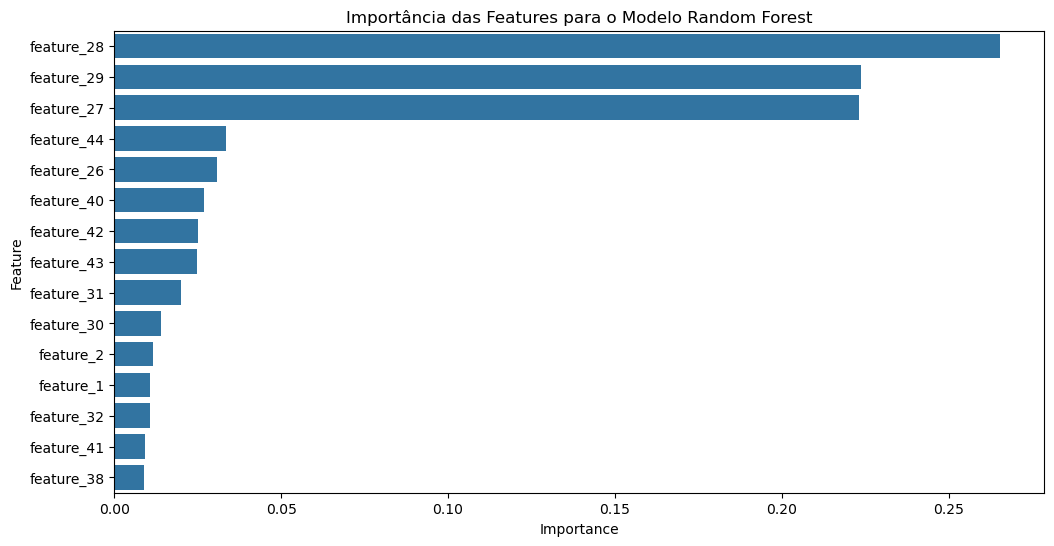

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(15))
plt.title("Importância das Features para o Modelo Random Forest")
plt.show()

### Dendograma de árvore de clusterização

In [ ]:
if "features" not in dataset.columns:
    raise ValueError("No features")
t1 = time.time()
pandas_df = dataset.toPandas()
print(f"Passo 1 concluído em {time.time() - t1:.2f} segundos")
t1 = time.time()
features_array = np.array(pandas_df["features"].apply(lambda x: np.array(x.toArray())).tolist())
print(f"Passo 2 concluído em {time.time() - t1:.2f} segundos")

print(f"{features_array.shape}")

In [ ]:
features_df = pd.DataFrame(features_array)
features_df.to_parquet("gs://path_oculto/gabriel.willye/perfil-laranja/features_array.parquet")


In [ ]:
features_df = spark.read.parquet('gs://path_oculto/gabriel.willye/perfil-laranja/features_array.parquet')

In [ ]:
import numpy as np

# Converter Spark DataFrame para Pandas primeiro
features_pandas = features_df.toPandas()

# Converter Pandas DataFrame para NumPy array
features_array = features_pandas.to_numpy()  # Ou features_pandas.values

# Verificar o formato
print(type(features_array))  # Deve mostrar: <class 'numpy.ndarray'>
print(features_array.shape)  # Formato do array


<class 'numpy.ndarray'>
(2500000, 46)


In [ ]:
t1 = time.time()
clusterer = hdbscan.HDBSCAN()
print(f"Passo 1 concluído em {time.time() - t1:.2f} segundos")
t1 = time.time()
clusterer.fit(features_array)
print(f"Passo 2 concluído em {time.time() - t1:.2f} segundos")

Passo 1 concluído em 0.00 segundos
Passo 2 concluído em 802.60 segundos


Da indo, amém


/opt/conda/miniconda3/lib/python3.11/site-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


Passo 1 concluído em 4866.51 segundos


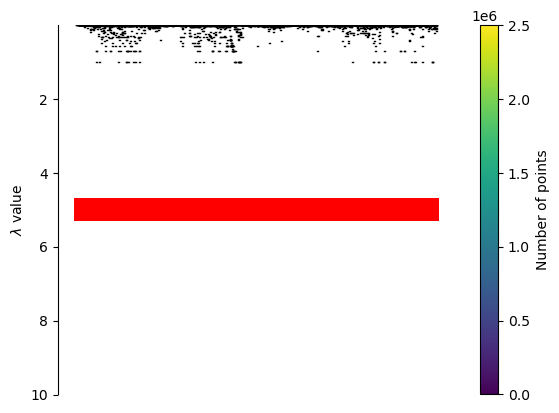

In [ ]:
t1 = time.time()
print("Da indo, amém")
clusterer.condensed_tree_.plot(select_clusters=True)
print(f"Passo 1 concluído em {time.time() - t1:.2f} segundos")

Passo 1 concluído em 3777.04 segundos


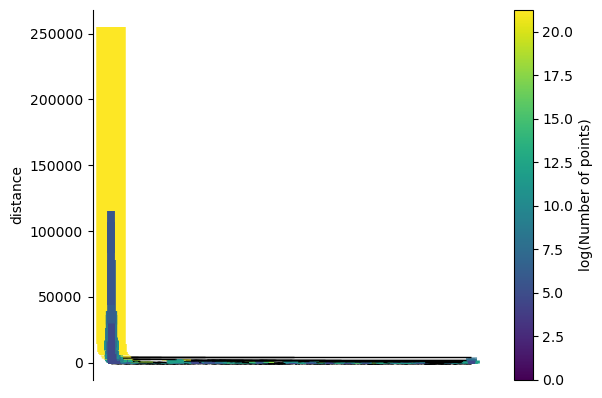

In [ ]:
import sys

sys.setrecursionlimit(100000)
t1 = time.time()
clusterer.single_linkage_tree_.plot(cmap="viridis", colorbar=True)
print(f"Passo 1 concluído em {time.time() - t1:.2f} segundos")

Passo 1 concluído em 20.59 segundos


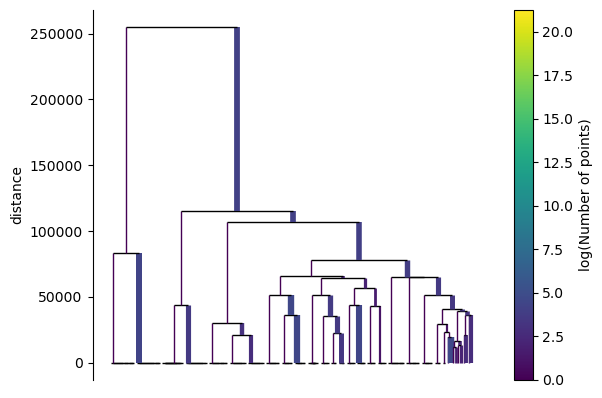

In [ ]:
import sys

sys.setrecursionlimit(100000)

t1 = time.time()
clusterer.single_linkage_tree_.plot(cmap="viridis", colorbar=True, truncate_mode="level", p=10)
print(f"Passo 1 concluído em {time.time() - t1:.2f} segundos")

In [ ]:
import joblib

t1 = time.time()
joblib.dump(clusterer, "clusterer.pkl")
print(f"Passo 1 concluído em {time.time() - t1:.2f} segundos")

from google.cloud import storage
import joblib

local_path = "clusterer.pkl"
joblib.dump(clusterer, local_path)

bucket_name = "path_oculto"
destination_blob = "gabriel.willye/perfil-laranja/clusterer.pkl"

client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(destination_blob)
blob.upload_from_filename(local_path)

print(f"Modelo salvo em gs://{bucket_name}/{destination_blob}")

In [ ]:
clusterer = spark.read.parquet('gs://path_oculto/gabriel.willye/batches/clusterer.parquet')

### Adaptação Isolation Forest - 2

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error

pandas_df = dataset.toPandas()

pandas_df["features_array"] = pandas_df["features"].apply(lambda x: np.array(x.toArray()))
features_expanded = np.vstack(pandas_df["features_array"].values)

feature_names = [f"feature_{i}" for i in range(features_expanded.shape[1])]
features_df = pd.DataFrame(features_expanded, columns=feature_names)

features_df["is_outlier"] = pandas_df["cluster"].apply(lambda x: 1 if x == -1 else 0)

# Treinamento do Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.02, max_samples=256, random_state=42)
iso_forest.fit(features_df[feature_names])  # Treinar apenas com as features

# Cálculo dos scores de anomalia
features_df["scoreAnomalia"] = iso_forest.decision_function(features_df[feature_names])

# Previsões de anomalia
features_df["anomalia"] = iso_forest.predict(features_df[feature_names])
features_df["anomalia"] = features_df["anomalia"].apply(lambda x: 1 if x == -1 else 0)

# Comparação entre HDBSCAN e Isolation Forest
print(features_df[["is_outlier", "anomalia"]].value_counts())

# Permutação para cálculo da importância das features
original_scores = iso_forest.decision_function(features_df[feature_names])

feature_importance = {}
for feature in feature_names:
    df_permuted = features_df[feature_names].copy()  # Only features
    df_permuted[feature] = np.random.permutation(df_permuted[feature])  # Value permutation

    permuted_scores = iso_forest.decision_function(df_permuted[feature_names])
    score_change = mean_squared_error(original_scores, permuted_scores)

    feature_importance[feature] = score_change

# Normalização das importâncias
max_importance = max(feature_importance.values())
for feature in feature_importance:
    feature_importance[feature] = (feature_importance[feature] / max_importance) * 100

# Criação do dataframe de importâncias
df_importance = pd.DataFrame(
    list(feature_importance.items()), columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)

df_importance["Importance"] = df_importance["Importance"].round(2)
print(df_importance.head(10))


is_outlier  anomalia
0           0           1955000
1           0            542500
0           1              1825
1           1               675
Name: count, dtype: int64
       Feature  Importance
43  feature_43      100.00
8    feature_8       57.39
3    feature_3       55.27
24  feature_24       53.03
40  feature_40       49.64
38  feature_38       48.59
18  feature_18       43.83
23  feature_23       41.64
44  feature_44       40.64
42  feature_42       35.95


In [ ]:
df_importance_spark = spark.createDataFrame(df_importance)
df_importance_spark.write.mode("overwrite").parquet(f"{sandbox_analytics}df_importance.parquet")


In [ ]:
df_importance = spark.read.parquet("gs://path_oculto/gabriel.willye/batches/df_importance.parquet/")
df_importance.head(10)

+----------+----------+
|   Feature|Importance|
+----------+----------+
|feature_34|       0.0|
|feature_20|       0.0|
|feature_19|       0.0|
|feature_15|       0.0|
|feature_14|       0.0|
|feature_13|       0.0|
|feature_12|       0.0|
|feature_11|       0.0|
|feature_10|       0.0|
| feature_0|       0.0|
|feature_35|      1.91|
|feature_25|      0.48|
|feature_16|      0.03|
| feature_6|       0.0|
|feature_22|       0.0|
|feature_17|     31.72|
|feature_21|      31.1|
|feature_32|     29.83|
|feature_30|     25.03|
|feature_41|     25.01|
+----------+----------+
only showing top 20 rows



In [ ]:
feature_names = dataset.schema["features"].metadata["ml_attr"]["attrs"]
feature_names = [attr["name"] for group in feature_names.values() for attr in group]

features_df = pd.DataFrame(features_expanded, columns=feature_names)

In [ ]:
import joblib
from google.cloud import storage
import io

client = storage.Client()
bucket_name = "path_oculto"
blob_path = "gabriel.willye/batches/iso_forest.pkl"

bucket = client.bucket(bucket_name)
blob = bucket.blob(blob_path)

buffer = io.BytesIO()
blob.download_to_file(buffer)
buffer.seek(0)

iso_forest = joblib.load(buffer)

print("Modelo Isolation Forest carregado com sucesso!")


Modelo Isolation Forest carregado com sucesso!


In [ ]:
print(f"Número de Árvores: {iso_forest.n_estimators}")

print(f"Taxa de Contaminação: {iso_forest.contamination}")

print("Parâmetros do modelo:")
print(iso_forest.get_params())

if hasattr(iso_forest, "feature_importances_"):
    print("Importância das Features:")
    print(iso_forest.feature_importances_)

Número de Árvores: 100
Taxa de Contaminação: 0.001
Parâmetros do modelo:
{'bootstrap': False, 'contamination': 0.001, 'max_features': 1.0, 'max_samples': 256, 'n_estimators': 100, 'n_jobs': None, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [ ]:
import joblib
import gcsfs

model_path = "gs://path_oculto/gabriel.willye/batches/iso_forest.pkl"

fs = gcsfs.GCSFileSystem()

with fs.open(model_path, "wb") as file:
    joblib.dump(iso_forest, file)

In [ ]:
import gcsfs
import joblib

model_path = "gs://path_oculto/gabriel.willye/batches/iso_forest.pkl"

fs = gcsfs.GCSFileSystem()

with fs.open(model_path, "rb") as file:
    iso_forest = joblib.load(file)

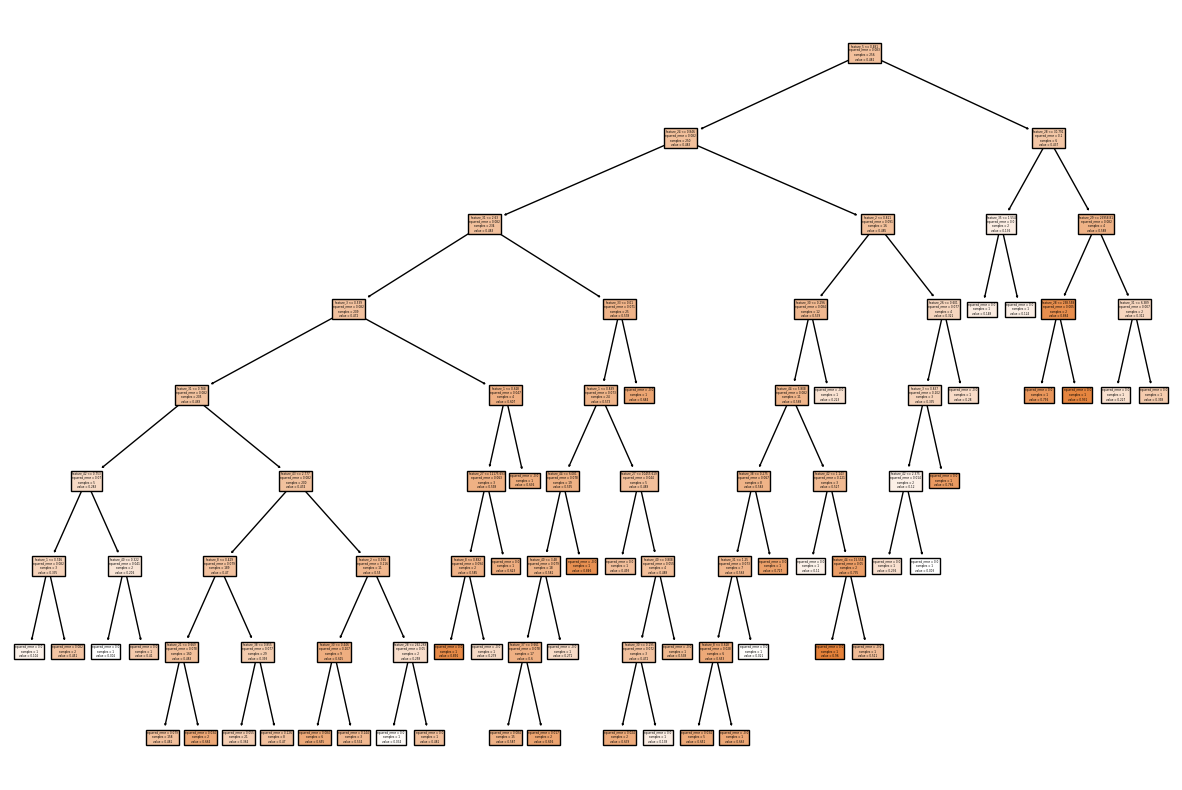

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Selecionar uma árvore individual do Isolation Forest
tree = iso_forest.estimators_[0]  # Pegamos a primeira árvore

# Plotar a árvore
plt.figure(figsize=(15, 10))
plot_tree(tree, feature_names=feature_names, filled=True)
plt.show()


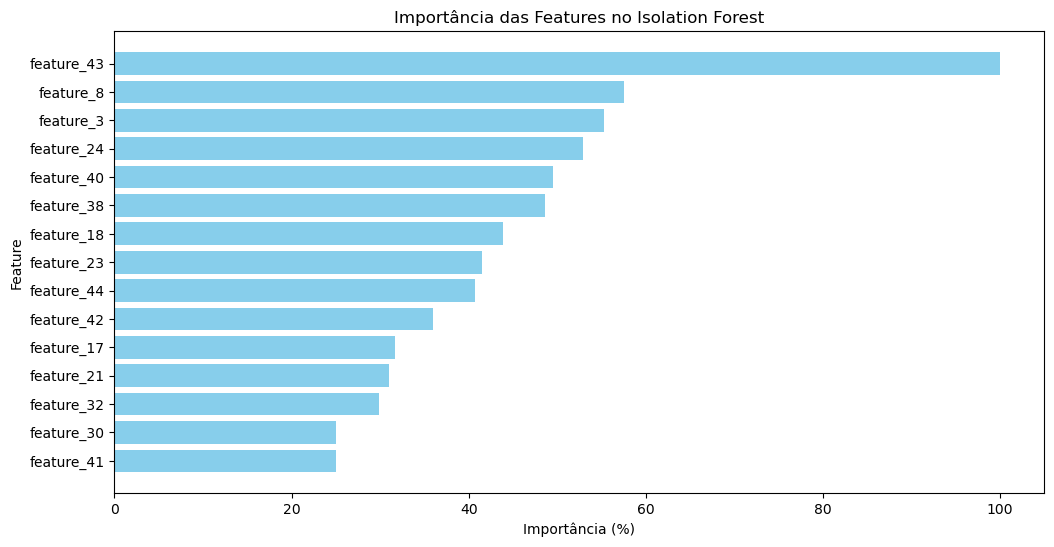

In [ ]:
from sklearn.metrics import mean_squared_error

original_scores = iso_forest.decision_function(features_df[feature_names])

feature_importance = {}

for feature in feature_names:
    df_permuted = features_df[feature_names].copy()
    df_permuted[feature] = np.random.permutation(df_permuted[feature])  # Permutação dos valores

    permuted_scores = iso_forest.decision_function(df_permuted)  # Score após permutação
    score_change = mean_squared_error(original_scores, permuted_scores)  # Impacto no score de anomalia

    feature_importance[feature] = score_change

max_importance = max(feature_importance.values())
for feature in feature_importance:
    feature_importance[feature] = (feature_importance[feature] / max_importance) * 100

df_importance = pd.DataFrame(list(feature_importance.items()), columns=["Feature", "Importance"])
df_importance = df_importance.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(df_importance["Feature"][:15], df_importance["Importance"][:15], color="skyblue")
plt.xlabel("Importância (%)")
plt.ylabel("Feature")
plt.title("Importância das Features no Isolation Forest")
plt.gca().invert_yaxis()
plt.show()

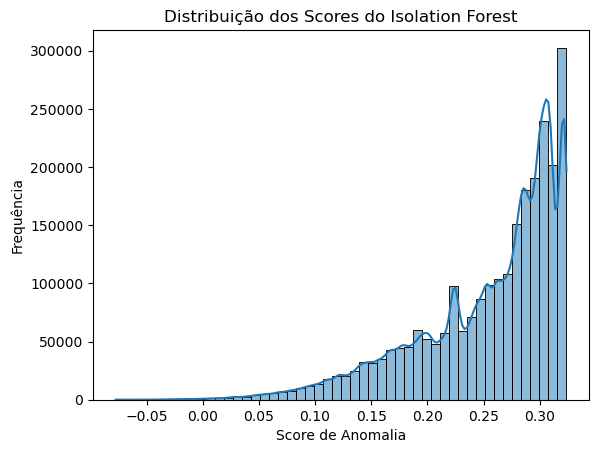

In [ ]:
sns.histplot(features_df["scoreAnomalia"], bins=50, kde=True)
plt.xlabel("Score de Anomalia")
plt.ylabel("Frequência")
plt.title("Distribuição dos Scores do Isolation Forest")
plt.show()

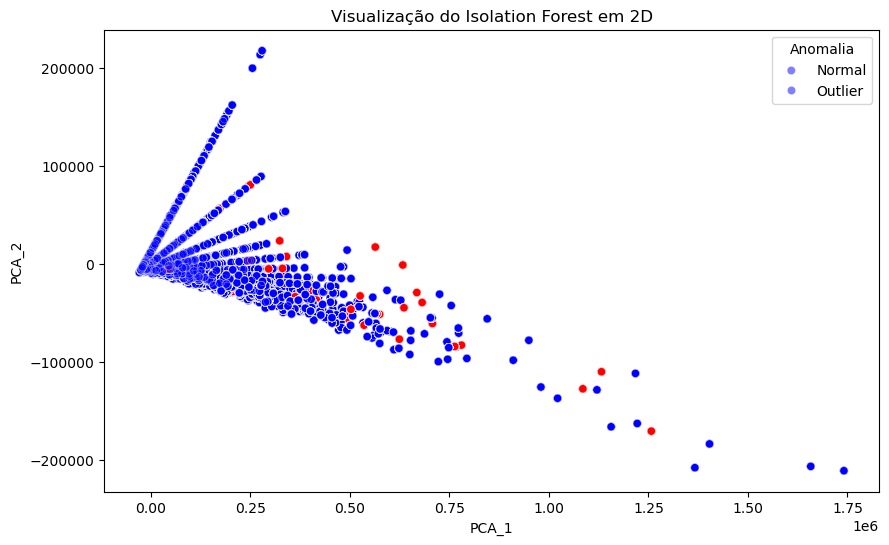

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_df[feature_names])

pca_df = features_df.copy()
pca_df["PCA_1"] = pca_result[:, 0]
pca_df["PCA_2"] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PCA_1", y="PCA_2", hue="anomalia", palette={0: "blue", 1: "red"}, alpha=0.5)
plt.title("Visualização do Isolation Forest em 2D")
plt.legend(title="Anomalia", labels=["Normal", "Outlier"])
plt.show()

In [ ]:
print(df_importance.head(45))

   Feature  Importance
43     NaN  100.000000
8      NaN   57.545608
3      NaN   55.306153
24     NaN   52.884501
40     NaN   49.534442
38     NaN   48.604634
18     NaN   43.911894
23     NaN   41.522263
44     NaN   40.680649
42     NaN   35.954534
17     NaN   31.727895
21     NaN   31.047415
32     NaN   29.833600
30     NaN   25.054333
41     NaN   24.999317
1      NaN   24.515071
5      NaN   23.850753
2      NaN   22.922971
37     NaN   20.775983
9      NaN   20.122874
31     NaN   19.982405
39     NaN   19.948039
7      NaN   18.493566
26     NaN   18.269955
27     NaN   17.945905
4      NaN   16.375814
29     NaN   11.727134
28     NaN   10.349102
33     NaN    4.227205
36     NaN    3.147737
35     NaN    1.916523
25     NaN    0.474896
16     NaN    0.027513
6      NaN    0.001251
22     NaN    0.000990
34     NaN    0.000000
20     NaN    0.000000
19     NaN    0.000000
15     NaN    0.000000
14     NaN    0.000000
13     NaN    0.000000
12     NaN    0.000000
11     NaN 

In [ ]:
print(feature_map["feature_0"])

features


   Feature  Importance
43     bancarizacaoMapeado  100.000000
8      flagBeneficiarioProgramasSociais   57.545608
3      flagEmpresario   55.306153
24     qntdFinanciamentosImobiliarios   52.884501
40     faixaFinanciamentoImobiliario   49.534442
38     flagFinanciadorMarcaPremium   48.604634
18     quantidadeMediaEmpresasMesmoCnaeAbertas12Meses   43.911894
23     qtdImoveisAltoValor   41.522263
44     diversificacaoMapeado   40.680649
42     ativosSemCotaMapeado   35.954534
17     flagSocioDuplaId   31.727895
21     flagSocioClasseEmpresaFachadaMUITOALTA   31.047415
32     qtdVeiculosFinanciados   29.833600
30     valFinanciadoSoma   25.054333
41     ativosComCotaMapeado   24.999317
1      flagAdolescente   24.515071
5      flagServidorPublico   23.850753
2      flagIdoso   22.922971
37     quantidadePropriedades   20.775983
9      flagAltaQualificacaoBeneficiarioProgramasSociais   20.122874
31     qteFinanciadoAtivo   19.982405
39     flagPossuiHistoricoAtrasoFinanciamento   19.948039
7      flagVulneravelBPC   18.493566
26     qteFinanciamentoQuitado   18.269955
27     qteTotalCompraVeiculo   17.945905
4      flagAltaQualificacao   16.375814
29     valFinanciadoMediaParcela   11.727134
28     valFinanciadoMedia   10.349102
33     qtdVeiculosAVista    4.227205
36     valorAreaTotalPropriedadesRurais    3.147737
35     quantidadeAeronaves    1.916523
25     qteFinanciamentoAtivo    0.474896
16     flagIndicioForteDuplaIdentidade    0.027513
6      flagProdutorRural    0.001251
22     qtdImoveis    0.000990
34     quantidadeVeiculosPesados    0.000000
20     flagSocioClasseEmpresaFachadaALTA    0.000000
19     flagSocioClasseEmpresaFachadaMEDIO    0.000000
15     quantidadeIndicioForteDuplaIdentidade    0.000000
14     flagDuplaIdentidadeCpfMae    0.000000
13     quantidadeDuplaIdentidadeCpfMae    0.000000
12     flagDuplaIdentidadeNomeMae    0.000000
11     quantidadeDuplaIdentidadeNomeMae    0.000000
10     flagDuplaIdentidadeNomeDataNascimento    0.000000
0      features    0.000000